# Peut-on se fier aux prévisions de températures de météo-France ? 

Ce projet est dédié à l'analyse des erreurs de prévisions de températures de météo France. Tout d'abord nous allons décrire les erreurs de prévsisions de températures, puis essayer de comprendre via d'atures variables météorologiques ces erreurs et les sources de ces erreurs, enfn nous allons essayer de faire des prédictions sur les températures prédites par météo france pour essayer d'approcher au mieux les températures réelles. La première partie se concentre sur une étude global de la France à l'aide de méthodes d'interpolation, la seconde utilise une approche plus micro pour étudier de façon précise certains territoires et enfin la troisième partie propose une étude rapiçde des Alpes afin de comparer de modèle français à celui des autres pays.

# Préliminaires : récupérations des données et préparations des data frame :

Obtention des données via le site open-meteo.com, nous allons nous concentrer dans un premier temps sur les températures prédites, et relevées en France sur l'année 2023.  

In [33]:
#importation de toutes les libraries et téléchargement des libraries peut courantes

!pip install openmeteo_requests
!pip install requests_cache
!pip install retry_requests
!pip install s3fs
!pip install pandas
!pip install numpy
!pip install matplotlib.pyplot
!pip install geopandas
!pip install random
!pip install shapely.geometry
!pip install cartiflette
!pip install cartopy
!pip install scipy
!pip install seaborn
!pip install scikit-learn

import openmeteo_requests
import numpy as np
import requests_cache
from retry_requests import retry
import requests
import time 
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import geopandas as gpd
from scipy.stats import pearsonr
import seaborn as sns
from shapely.geometry import Point
from scipy.optimize import curve_fit
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import random
from cartiflette import carti_download
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Polygon, Point, MultiPolygon
from shapely.prepared import prep
from matplotlib.path import Path
import scipy.interpolate
from scipy.interpolate import griddata, Rbf

ERROR: Could not find a version that satisfies the requirement matplotlib.pyplot (from versions: none)
ERROR: No matching distribution found for matplotlib.pyplot


ERROR: Could not find a version that satisfies the requirement random (from versions: none)
ERROR: No matching distribution found for random
ERROR: Could not find a version that satisfies the requirement shapely.geometry (from versions: none)
ERROR: No matching distribution found for shapely.geometry


Deux méthodes d'analyses vont être effectuées. La première sélectionne un échantillon aléatoire de points en France métropolitaine et analyse à partir de ces points les erreurs de prévisions. La seconde se base sur la localisation des communes de France, considérées comme des endroits d'intérêt particulier.

Pour cette deuxième méthode, nous utilisons le fichier des communes de France établi par l'INSEE. Ce fichier associe à chaque commune une longitude, une latitude, un département, une région et un nom. Nous allons nous concentrer uniquement sur les coordonnées géographiques de chaque commune. Cependant, avec plus de 38 000 communes en France, 365 jours en 2023 et 24 heures par jour, cela représenterait 332 880 000 lignes dans un tableau de données, ce qui est trop volumineux pour être traité par mon ordinateur.

Par conséquent, nous allons nous concentrer sur un échantillon de 2719 communes. Bien que cet échantillon ne soit pas aléatoire (car le fichier est trié par ordre alphabétique), nous avons choisi des communes consécutives afin d'assurer une certaine proximité géographique. Cette approche devrait renforcer la robustesse des résultats, car les variations de localisation seront moins importantes

# I/Etude générale

L'objectif de cette première partie est de présenter l'interpolation et de donner une approche générale des températures en France, on commence par importer la carte de France selon la projection crs, puis on générère aléatoirement selon une loi uniforme des points, nous avons volontairement choisi des points qui n'étaient pas dans la France pour que les méthodes d'interpolations soient aussi valable aux frontières de la France. 

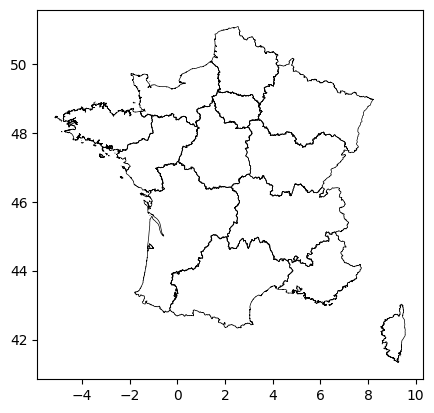

In [34]:
from cartiflette import carti_download

france = carti_download(
    values=["France"],
    crs=4326,
    borders="REGION",
    vectorfile_format="geojson",
    simplification=50,
    filter_by="FRANCE_ENTIERE",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022,
)

# Transformer la France en un GeoDataFrame avec uniquement la France métropolitaine
france_gdf = france[france["INSEE_REG"] > 10]  # Exclure les régions d'outre-mer

france = france.loc[france["INSEE_REG"] > 10] # Exclure les régions d'outre-mer
france_4326 = france.to_crs(4326)
ax1 = france_4326.boundary.plot(edgecolor="k", linewidth=0.5)

In [35]:
def generate_random_points_in_france(num_points=50, seed=42):
    """
    Génère un ensemble de points aléatoires situés dans les limites de la France métropolitaine.
    Les points générés sont reproductibles grâce à une graine fixe.

    Args:
        num_points (int): Nombre de points aléatoires à générer.
        seed (int): Graine pour la génération aléatoire (par défaut : 42).

    Returns:
        list: Liste de tuples contenant les coordonnées (latitude, longitude).
    """
    # Fixer la graine pour rendre les points reproductibles
    random.seed(seed)
    
    points = []
    # Obtenir la géométrie de la France métropolitaine
    france_geom = france_gdf.unary_union  # Fusionner toutes les géométries pour simplifier la vérification

    # Générer des points aléatoires jusqu'à ce qu'ils soient dans la France métropolitaine
    while len(points) < num_points:
        lat = random.uniform(41.0, 51.5)  # Latitude approximée
        lon = random.uniform(-5.0, 10.0)   # Longitude approximée
        points.append((lat, lon))

    return points

On importe grâce à l'API de météo-France la moyenne des données de température à 2m prévues pour le mois de janvier en fonction des années (ce choix est arbitraire).

In [36]:
def temperature_random_points_in_month(nb_points : int) -> pd.DataFrame  :
    # Liste des points aléatoires (exemple avec 2 points, étendre à 100 points)
    random_points = generate_random_points_in_france(nb_points)

    # Date unique pour la requête (remplacez par la date souhaitée)

    # Setup the Open-Meteo API client with cache and retry on error
    cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
    retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
    openmeteo = openmeteo_requests.Client(session=retry_session)

    # Créer un DataFrame consolidé pour stocker les résultats
    dataframes = []
    for year in range (2023,2025):
        # Effectuer une requête pour chaque point
        for idx, (latitude, longitude) in enumerate(random_points, start=1):
            print(f"Traitement du point {idx}: Latitude = {latitude}, Longitude = {longitude}")

            # Paramètres de la requête pour chaque point
            params = {
                "latitude": latitude,
                "longitude": longitude,
                "hourly": "temperature_2m",
                "start_date": f"{year}-01-01",
                "end_date": f"{year}-01-31",
                "models": "meteofrance_seamless"
            }

            try:
                # Effectuer la requête Open-Meteo
                responses = openmeteo.weather_api("https://archive-api.open-meteo.com/v1/archive", params=params)
                response = responses[0]

                # Extraire les données horaires pour la température à 2m
                hourly = response.Hourly()
                hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()

                hourly_data = {
                    "date": pd.date_range(
                        start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
                        end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
                        freq=pd.Timedelta(seconds=hourly.Interval()),
                        inclusive="left"
                    ),
                    "temperature_2m": hourly_temperature_2m
                }

                # Ajouter la latitude et la longitude aux données
                hourly_data["latitude"] = latitude
                hourly_data["longitude"] = longitude

                # Convertir en DataFrame et ajouter à la liste
                df = pd.DataFrame(data=hourly_data)
                dataframes.append(df)

            except Exception as e:
                print(f"Erreur lors du traitement du point {idx}: {e}")

    # Concaténation de tous les DataFrames
    final_dataframe = pd.concat(dataframes, ignore_index=True)

    # Sauvegarde des résultats dans un fichier CSV
    final_dataframe.to_csv("weather_data.csv", index=False)

    result = final_dataframe.rename(columns = {'temperature_2m' : 'temperature'})

    result['date'] = result['date'].dt.year
    
    result_group = result.groupby(by=["latitude", "longitude", 'date'])[["temperature"]].mean().reset_index()
    result_group.tail()
    
    return result_group

On crée une fonction qui renvoie une liste de dataframe avec les températures (un dataframe par année)

In [37]:
def all_map(df: pd.DataFrame):
    # Filtrer les lignes où 'temperature' n'est pas NaN
    filtered_df = df[~df['temperature'].isna()]
    
    # Créer une liste pour stocker les DataFrames par année
    result_list = []
    
    # Itérer sur chaque année présente dans 'date'
    for date in filtered_df['date'].unique():
        matching_rows = df[df['date'] == date]
        
        # Ajouter le DataFrame correspondant à l'année à la liste
        result_list.append(matching_rows)
        
        # Optionnel: Vous pouvez aussi nommer chaque DataFrame pour le rendre identifiable
        # Par exemple: result_<année> = matching_rows, mais cela n'est pas pratique dans une fonction.
    
    # Retourner la liste de DataFrames
    return result_list

Ici, nous avons rencontré un gros problème. Bien que le site indique qu'il est possible d'obtenir les données jusqu'en 1940, il faut 5 jours pour les récupérer. Nous avons fait les démarches il y a une semaine, et nous n'avons toujours pas de nouvelles. Pour des raisons de simplicité, nous avons donc utilisé les données disponibles, c'est-à-dire uniquement celles de 2023 et 2024.

In [38]:
result = temperature_random_points_in_month(300)
listdf = all_map(result)
resultat = listdf[1] #pour obtenir les température de 2024

C:\Users\tsang\AppData\Local\Temp\ipykernel_11176\2090913568.py:18: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  france_geom = france_gdf.unary_union  # Fusionner toutes les géométries pour simplifier la vérification


Traitement du point 1: Latitude = 47.71398138380778, Longitude = -4.624838671659996
Traitement du point 2: Latitude = 43.88780784287575, Longitude = -1.6518389277676588
Traitement du point 3: Latitude = 48.73294774872213, Longitude = 5.150492311343669
Traitement du point 4: Latitude = 50.36788546090088, Longitude = -3.6959175105587576
Traitement du point 5: Latitude = 45.43017910669534, Longitude = -4.553041708428945
Traitement du point 6: Latitude = 43.29569873543784, Longitude = 2.580329321550436
Traitement du point 7: Latitude = 41.27862768168057, Longitude = -2.017435239700273
Traitement du point 8: Latitude = 47.823786596685, Longitude = 3.1741222090482495
Traitement du point 9: Latitude = 43.314626531427315, Longitude = 3.8389852581386315
Traitement du point 10: Latitude = 49.49901979511718, Longitude = -4.902518604829085
Traitement du point 11: Latitude = 49.461102144244485, Longitude = 5.472090924823403
Traitement du point 12: Latitude = 44.572630423438916, Longitude = -2.66780

Ensuite on affiche sur une carte les points obtenue et la couleur en fonction de la température.

In [39]:
def map_with_point(result):
    # Convertir le DataFrame pandas en GeoDataFrame avec la projection EPSG:4326
    geometry = [Point(xy) for xy in zip(result["longitude"], result["latitude"])]
    geo_result = gpd.GeoDataFrame(result, geometry=geometry, crs="EPSG:4326")

    # Reprojections de vos points en Lambert-93 (pour correspondre à france_4326)
    geo_result_4326 = geo_result.to_crs(4326)

    # Afficher la carte avec la France et les températures sur celle-ci
    fig, ax = plt.subplots(figsize=(10, 10))

    # Afficher les frontières de la France métropolitaine
    france_4326.boundary.plot(ax=ax, edgecolor="k", linewidth=0.5)

    # Afficher les points de température sur la carte
    # Utiliser une couleur pour représenter la température
    geo_result_4326.plot(ax=ax, column="temperature", cmap="coolwarm", markersize=20, legend=True)

    # Afficher la carte avec les bonnes coordonnées GPS (EPSG:4326)
    ax.set_title("Carte des frontières de la France Métropolitaine ", fontsize=14)
    ax.set_xlabel("Longitude ", fontsize=12)
    ax.set_ylabel("Latitude ", fontsize=12)
    plt.tight_layout()


    # Afficher la carte
    plt.show()

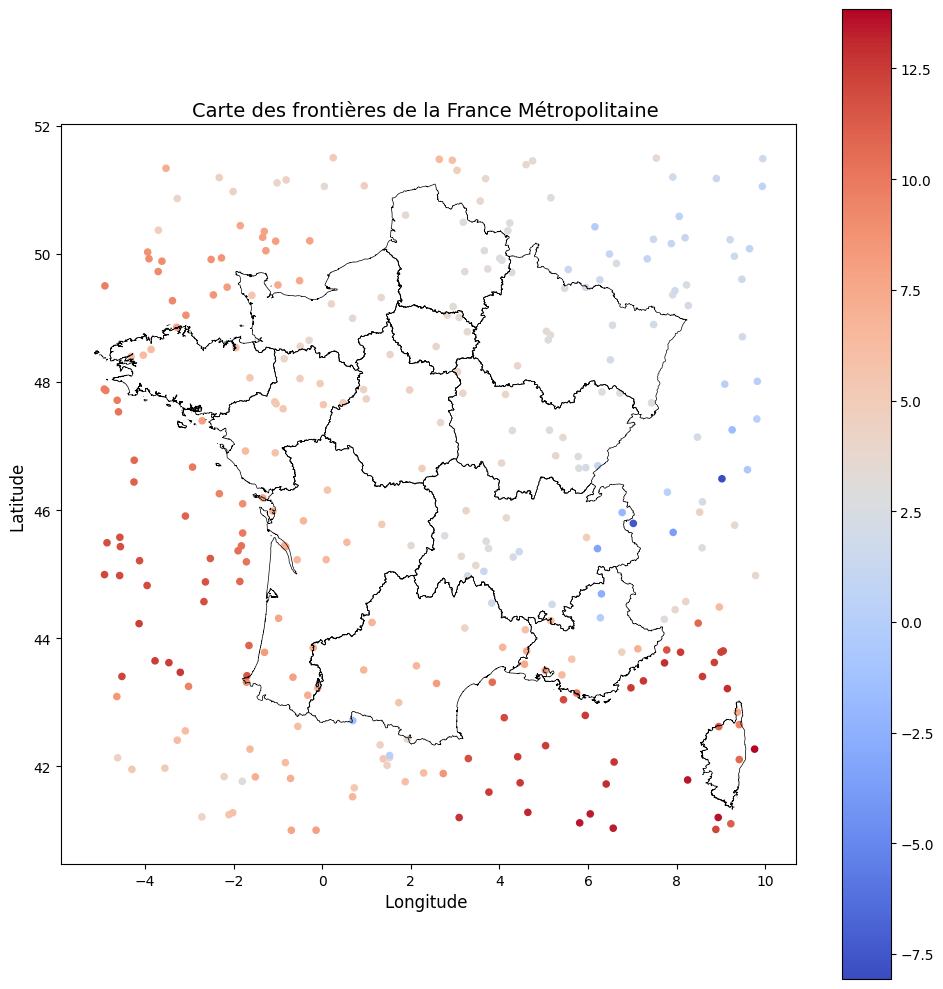

In [40]:
map_with_point(resultat)

L'objectif suivant est de faire de l'interpolation, c'est-à-dire d'estimer des valeurs inconnues à l'intérieur d'une plage donnée de données connues. Cela consiste à construire une fonction ou une relation qui passe par un ensemble de points existants pour prédire les valeurs intermédiaires. Nous avons ici choisi deux méthodes :

## Interpolation par IDW (Inverse Distance Weighting) :

### Principe
La méthode IDW estime une valeur en un point inconnu ( P ) comme une moyenne pondérée des valeurs des points voisins. Les poids sont inversement proportionnels à la distance entre le point ( P ) et les points connus ( P_i ).

#### Formule
[
f(P) = \frac{\sum_{i=1}^n \frac{f(P_i)}{d(P, P_i)^p}}{\sum_{i=1}^n \frac{1}{d(P, P_i)^p}}
]

( f(P) ) : Valeur interpolée au point ( P ),
( f(P_i) ) : Valeur connue au point ( P_i ),
( d(P, P_i) ) : Distance entre ( P ) et ( P_i ),
( p ) : Puissance contrôlant l'influence des points (généralement ( p = 2 )),
( n ) : Nombre de points voisins utilisés.
Un des défauts est de produire des surfaces lisses qui peuvent ne pas respecter les variations locales. Elle est par ailleurs très sensible au choix de ( p ) et des voisins.

## Interpolation par Triangulation de Delaunay

### Principe
La triangulation de Delaunay divise un ensemble de points en triangles de manière à maximiser l'angle minimum dans chaque triangle (réduit les triangles "plats"). L’interpolation linéaire est ensuite réalisée à l'intérieur de chaque triangle.

#### Étapes
Créer une triangulation de Delaunay sur les points connus.
Identifier le triangle contenant le point à interpoler.
Effectuer une interpolation linéaire à l'intérieur de ce triangle en utilisant les trois sommets.
Cependant, elle peut donner une surface angulaire (non lisse) et est peu performante pour des données très irrégulières ou avec des gradients abrupts, ce qui peut être le cas avec des données de températures.

In [41]:
class TemperatureInterpolation:
    def __init__(self, dataframe):
        """
        Initialise l'interpolation avec un DataFrame pandas
        
        :param dataframe: DataFrame avec colonnes 'longitude', 'latitude', 'temperature'
        """
        self.points = dataframe[['longitude', 'latitude']].values
        self.temperatures = dataframe['temperature'].values
    
    def interpolate_idw(self, grid_shape=(500, 500), power=2):
        """
        Interpolation par Inverse Distance Weighting (IDW)
        
        :param grid_shape: Résolution de la grille de sortie
        :param power: Puissance pour le calcul des poids
        :return: Carte interpolée
        """
        # Créer une grille
        x = np.linspace(self.points[:,0].min(), self.points[:,0].max(), grid_shape[0])
        y = np.linspace(self.points[:,1].min(), self.points[:,1].max(), grid_shape[1])
        grid_x, grid_y = np.meshgrid(x, y)
        
        # Calcul des poids
        interpolated = np.zeros_like(grid_x, dtype=float)
        for i in range(grid_x.shape[0]):
            for j in range(grid_x.shape[1]):
                point = np.array([grid_x[i,j], grid_y[i,j]])
                
                # Calculer les distances
                distances = np.linalg.norm(self.points - point, axis=1)
                
                # Éviter la division par zéro
                distances = np.maximum(distances, 1e-10)
                
                # Calculer les poids
                weights = 1.0 / (distances ** power)
                weights /= np.sum(weights)
                
                # Interpolation pondérée
                interpolated[i,j] = np.sum(weights * self.temperatures)
        
        return interpolated, x, y
    
    def interpolate_triangulation(self, grid_shape=(500, 500)):
        """
        Interpolation par triangulation de Delaunay
        
        :param grid_shape: Résolution de la grille de sortie
        :return: Carte interpolée
        """
        x = np.linspace(self.points[:,0].min(), self.points[:,0].max(), grid_shape[0])
        y = np.linspace(self.points[:,1].min(), self.points[:,1].max(), grid_shape[1])
        grid_x, grid_y = np.meshgrid(x, y)
        
        # Interpolation par griddata (basée sur Delaunay)
        interpolated = griddata(self.points, self.temperatures, 
                                (grid_x, grid_y), method='cubic')
        
        return interpolated, x, y
    
    def plot_interpolation(self, interpolated, x, y, title='Interpolation de Température'):
        """
        Visualiser l'interpolation
        
        :param interpolated: Grille interpolée
        :param x: Coordonnées x
        :param y: Coordonnées y
        :param title: Titre du graphique
        """
        plt.figure(figsize=(12, 10))
        
        # Affichage de l'interpolation
        im = plt.imshow(interpolated, 
                        extent=[x.min(), x.max(), y.min(), y.max()], 
                        origin='lower', 
                        cmap='coolwarm', 
                        aspect='auto')
        plt.colorbar(im, label='Température')
        
        # Points d'origine
        scatter = plt.scatter(self.points[:,0], self.points[:,1], 
                              c=self.temperatures, 
                              cmap='coolwarm', 
                              edgecolor='black', 
                              s=100)
        
        plt.title(title)
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.tight_layout()
        plt.show()
    
    def interpolate_and_plot(self, method='triangulation', **kwargs):
        """
        Interpoler et tracer la carte
        
        :param method: Méthode d'interpolation ('idw' ou 'triangulation')
        :param kwargs: Paramètres supplémentaires pour la méthode
        """
        if method.lower() == 'idw':
            interpolated, x, y = self.interpolate_idw(**kwargs)
        elif method.lower() == 'triangulation':
            interpolated, x, y = self.interpolate_triangulation(**kwargs)
        else:
            raise ValueError("Méthode non reconnue. Choisissez 'idw' ou 'triangulation'.")
        
        self.plot_interpolation(interpolated, x, y)



In [42]:
def create_mask_vectorized(x, y, polygon):
    """Crée un masque de manière vectorisée en utilisant matplotlib Path"""
    # Convertir le polygone en format Path de matplotlib
    if isinstance(polygon, MultiPolygon):
        # Créer un masque combiné pour tous les polygones
        mask = np.zeros((len(y), len(x)), dtype=bool)
        for geom in polygon.geoms:
            polygon_coords = np.array(geom.exterior.coords.xy).T
            path = Path(polygon_coords)
            # Créer une grille de points
            points = np.column_stack((X.flatten(), Y.flatten()))
            # Tester tous les points d'un coup
            mask_part = path.contains_points(points).reshape(X.shape)
            mask = mask | mask_part
        return mask
    else:
        polygon_coords = np.array(polygon.exterior.coords.xy).T
        path = Path(polygon_coords)
        # Créer une grille de points
        points = np.column_stack((X.flatten(), Y.flatten()))
        # Tester tous les points d'un coup
        return path.contains_points(points).reshape(X.shape)


def interpoler_carte_france(resultat, ): 
    # Créer la grille
    interpolator = TemperatureInterpolation(resultat)
    interpolated, x, y = interpolator.interpolate_idw()
    X, Y = np.meshgrid(x, y)

    # Simplifier la forme de la France
    france_shape = france_gdf.geometry.unary_union
    test = france_shape.simplify(0.01)

    # Créer le masque de manière optimisée
    mask = create_mask_vectorized(x, y, test)

    # Appliquer le masque
    interpolated_masked = np.where(mask, interpolated, np.nan)

    # Création de la figure
    plt.figure(figsize=(10, 8))
    im = plt.imshow(interpolated_masked,
                    extent=[x.min(), x.max(), y.min(), y.max()],
                    origin='lower',
                    cmap='coolwarm',
                    aspect='auto')

    plt.colorbar(im, label='Température')

    # Tracer les frontières
    if isinstance(test, MultiPolygon):
        for geom in test.geoms:
            x_border, y_border = geom.exterior.xy
            plt.plot(x_border, y_border, 'k-', linewidth=1)
    else:
        x_border, y_border = test.exterior.xy
        plt.plot(x_border, y_border, 'k-', linewidth=1)

    plt.title('Carte des températures avec frontières')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.tight_layout()
    plt.show()

In [43]:
def plot_temperature_map(resultat, interpolator, method, france_gdf, year):
    """
    Génère et affiche une carte des températures avec les frontières de la France.
    
    Arguments :
    - resultat : DataFrame contenant les données de température à interpoler.
    - interpolator : Objet contenant la méthode d'interpolation (IDW ou Triangulation).
    - method : Méthode d'interpolation ('idw' ou 'triangulation').
    - france_gdf : GeoDataFrame contenant la géométrie des frontières de la France.
    
    Sortie :
    - Affiche une carte des températures avec les frontières de la France.
    """

    interpolator = TemperatureInterpolation(resultat)

    # Interpolation
    if method == 'idw':
        interpolated, x, y = interpolator.interpolate_idw()
    elif method == 'triangulation':
        interpolated, x, y = interpolator.interpolate_triangulation()
    else:
        raise ValueError("La méthode d'interpolation doit être 'idw' ou 'triangulation'")

    # Création d'un meshgrid pour les coordonnées
    X, Y = np.meshgrid(x, y)

    # Simplification de la géométrie des frontières de la France
    france_shape = france_gdf.geometry.unary_union
    test = france_shape.simplify(0.01)

    # Créer le masque optimisé avec la fonction de vectorisation
    mask = create_mask_vectorized(x, y, test)

    # Appliquer le masque aux données interpolées
    interpolated_masked = np.where(mask, interpolated, np.nan)

    # Création de la figure pour afficher les données
    plt.figure(figsize=(10, 8))
    im = plt.imshow(interpolated_masked,
                    extent=[x.min(), x.max(), y.min(), y.max()],
                    origin='lower',
                    cmap='coolwarm',
                    aspect='auto')

    plt.colorbar(im, label='Température')

    # Tracer les frontières simplifiées de la France
    if isinstance(test, MultiPolygon):
        for geom in test.geoms:
            x_border, y_border = geom.exterior.xy
            plt.plot(x_border, y_border, 'k-', linewidth=1)
    else:
        x_border, y_border = test.exterior.xy
        plt.plot(x_border, y_border, 'k-', linewidth=1)

    # Ajouter des titres et labels
    plt.title(f'Carte des températures en {year}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.tight_layout()
    plt.show()

Cette fonction affiche les évolution de la température, vu que seulement deux dates sont disonibles, ce n'est pas très pertinent, nous avons tout de même choisi de le montrer.

In [44]:
interpolator = TemperatureInterpolation(resultat)
interpolated, x, y = interpolator.interpolate_triangulation()
X, Y = np.meshgrid(x, y)

def plot_all_map(listdf : list):
    for i in range(len(listdf)):
        interpolator = TemperatureInterpolation(listdf[i])
        year = 2023 + i 
        plot_temperature_map(listdf[i], interpolator, year=year, method='idw', france_gdf=france_gdf)



C:\Users\tsang\AppData\Local\Temp\ipykernel_11176\1492390575.py:29: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  france_shape = france_gdf.geometry.unary_union


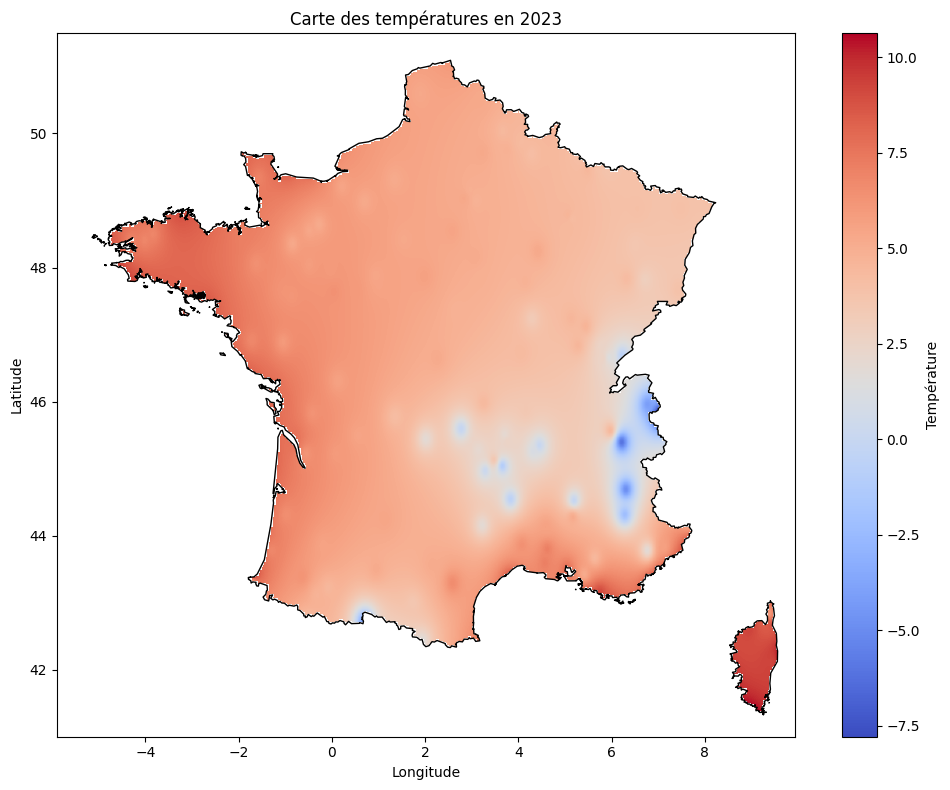

C:\Users\tsang\AppData\Local\Temp\ipykernel_11176\1492390575.py:29: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  france_shape = france_gdf.geometry.unary_union


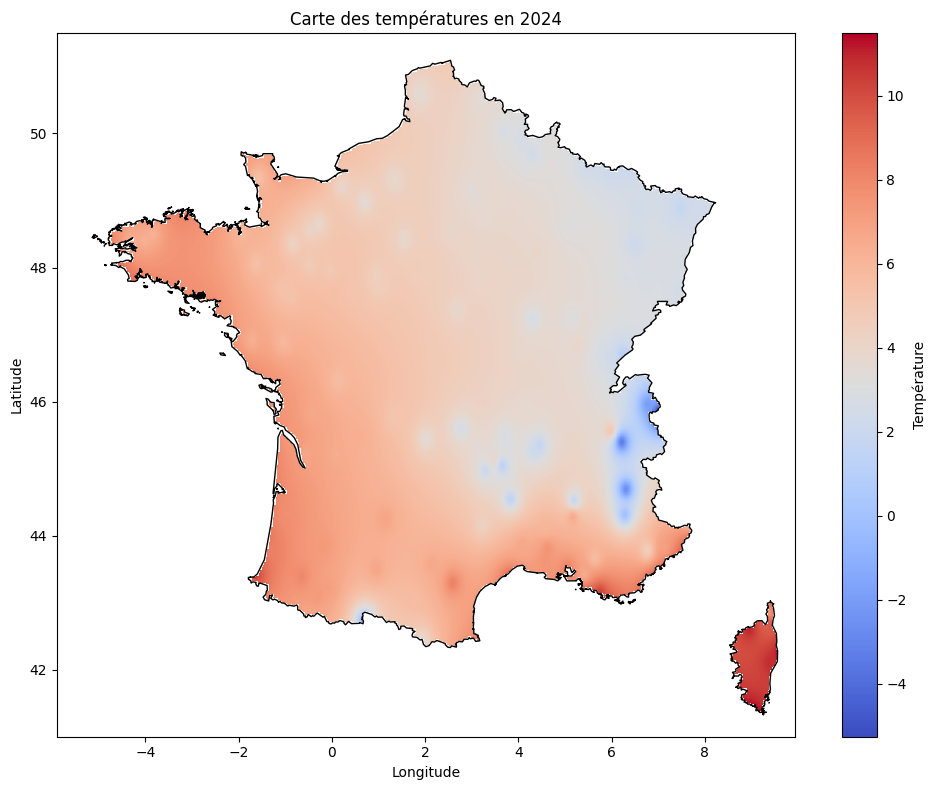

In [45]:
plot_all_map(listdf)

On importe les température moyenne préduites sur le mois de janvier

In [46]:
def temperature_random_points_forecast(nb_points : int, seed: int = 42) -> pd.DataFrame  :

    # Liste des points aléatoires (exemple avec 2 points, étendre à 100 points)
    random_points = generate_random_points_in_france(nb_points, seed)

    # Date unique pour la requête
    date = "2024-12-02"

    # Setup the Open-Meteo API client with cache and retry on error
    cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
    retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
    openmeteo = openmeteo_requests.Client(session=retry_session)

    # Créer un DataFrame consolidé pour stocker les résultats
    dataframes = []

    # Effectuer une requête pour chaque point
    for idx, (latitude, longitude) in enumerate(random_points, start=1):
        print(f"Traitement du point {idx}: Latitude = {latitude}, Longitude = {longitude}")

        # Paramètres de la requête pour chaque point
        params = {
            "latitude": latitude,
            "longitude": longitude,
            "hourly": "temperature_2m",
            "start_date": date,
            "end_date": date,
        }

        try:
            # Effectuer la requête Open-Meteo
            responses = openmeteo.weather_api("https://historical-forecast-api.open-meteo.com/v1/forecast", params=params)
            response = responses[0]

            # Extraire les données horaires pour la température à 2m
            hourly = response.Hourly()
            hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()

            hourly_data = {
                "date": pd.date_range(
                    start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
                    end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
                    freq=pd.Timedelta(seconds=hourly.Interval()),
                    inclusive="left"
                ),
                "temperature_2m": hourly_temperature_2m
            }

            # Ajouter la latitude et la longitude aux données
            hourly_data["latitude"] = latitude
            hourly_data["longitude"] = longitude

            # Convertir en DataFrame et ajouter à la liste
            df = pd.DataFrame(data=hourly_data)
            dataframes.append(df)

        except Exception as e:
            print(f"Erreur lors du traitement du point {idx}: {e}")

    # Concaténation de tous les DataFrames
    final_dataframe = pd.concat(dataframes, ignore_index=True)

    # Sauvegarde des résultats dans un fichier CSV
    final_dataframe.to_csv("weather_data.csv", index=False)

    result = final_dataframe.loc[final_dataframe["date"] == "2024-12-02 00:00:00+00:00"].rename(columns = {'temperature_2m' : 'temperature'})
    
    
    return result


def temperature_random_points_historical(nb_points : int, seed: int = 42) -> pd.DataFrame  :

    # Liste des points aléatoires (exemple avec 2 points, étendre à 100 points)
    random_points = generate_random_points_in_france(nb_points, seed)

    # Date unique pour la requête (remplacez par la date souhaitée)
    date = "2024-12-02"

    # Setup the Open-Meteo API client with cache and retry on error
    cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
    retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
    openmeteo = openmeteo_requests.Client(session=retry_session)

    # Créer un DataFrame consolidé pour stocker les résultats
    dataframes = []

    # Effectuer une requête pour chaque point
    for idx, (latitude, longitude) in enumerate(random_points, start=1):
        print(f"Traitement du point {idx}: Latitude = {latitude}, Longitude = {longitude}")

        # Paramètres de la requête pour chaque point
        params = {
            "latitude": latitude,
            "longitude": longitude,
            "hourly": "temperature_2m",
            "start_date": date,
            "end_date": date,
            "models": "meteofrance_seamless"
        }

        try:
            # Effectuer la requête Open-Meteo
            responses = openmeteo.weather_api("https://archive-api.open-meteo.com/v1/archive", params=params)
            response = responses[0]

            # Extraire les données horaires pour la température à 2m
            hourly = response.Hourly()
            hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()

            hourly_data = {
                "date": pd.date_range(
                    start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
                    end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
                    freq=pd.Timedelta(seconds=hourly.Interval()),
                    inclusive="left"
                ),
                "temperature_2m": hourly_temperature_2m
            }

            # Ajouter la latitude et la longitude aux données
            hourly_data["latitude"] = latitude
            hourly_data["longitude"] = longitude

            # Convertir en DataFrame et ajouter à la liste
            df = pd.DataFrame(data=hourly_data)
            dataframes.append(df)

        except Exception as e:
            print(f"Erreur lors du traitement du point {idx}: {e}")

    # Concaténation de tous les DataFrames
    final_dataframe = pd.concat(dataframes, ignore_index=True)

    # Sauvegarde des résultats dans un fichier CSV
    final_dataframe.to_csv("weather_data.csv", index=False)

    result = final_dataframe.loc[final_dataframe["date"] == "2024-12-02 00:00:00+00:00"].rename(columns = {'temperature_2m' : 'temperature'})
    
    
    return result


result_historical_12_01 = temperature_random_points_historical(400, seed=123)
result_forecast_12_01 = temperature_random_points_forecast(400, seed=123)

historical = result_historical_12_01.reset_index()
forecast = result_forecast_12_01.reset_index()

result_diff_forecast_historical = historical.copy()
result_diff_forecast_historical['temperature'] = historical['temperature'] - forecast['temperature']

interpolator = TemperatureInterpolation(result_diff_forecast_historical)

interpolated, x, y = interpolator.interpolate_triangulation()
X, Y = np.meshgrid(x, y)

C:\Users\tsang\AppData\Local\Temp\ipykernel_11176\2090913568.py:18: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  france_geom = france_gdf.unary_union  # Fusionner toutes les géométries pour simplifier la vérification


Traitement du point 1: Latitude = 41.54981778793491, Longitude = -3.692199837160515
Traitement du point 2: Latitude = 45.27603851853918, Longitude = -3.384496475923414
Traitement du point 3: Latitude = 50.4625882184928, Longitude = -4.427695008465164
Traitement du point 4: Latitude = 46.63012142035623, Longitude = -0.01703452235480274
Traitement du point 5: Latitude = 49.94690949875837, Longitude = -2.6050640491704513
Traitement du point 6: Latitude = 44.540774899647396, Longitude = 0.006945919434329539
Traitement du point 7: Latitude = 43.57421520143492, Longitude = -4.9749416963116575
Traitement du point 8: Latitude = 45.580895830859795, Longitude = -3.685797503743657
Traitement du point 9: Latitude = 47.2747943771239, Longitude = -3.9518455781122634
Traitement du point 10: Latitude = 44.31231922422656, Longitude = 1.724825624604156
Traitement du point 11: Latitude = 50.50668584898724, Longitude = -3.6085315793225736
Traitement du point 12: Latitude = 42.49283817653076, Longitude = 6

On affiche ici les deux résultats obtenus à l'aide de dexu interpolation différentes, la première est idw et la seconde la triangularisation de Delaunay.

C:\Users\tsang\AppData\Local\Temp\ipykernel_11176\1492390575.py:29: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  france_shape = france_gdf.geometry.unary_union


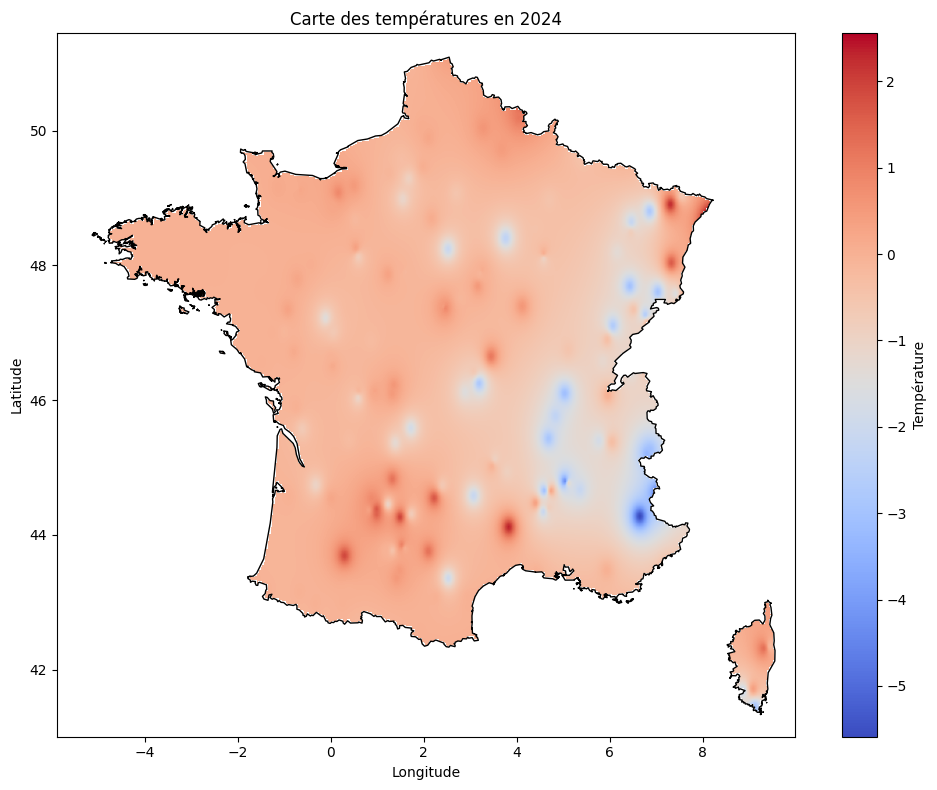

In [47]:
plot_temperature_map(result_diff_forecast_historical, interpolator, year=2024, method='idw', france_gdf=france_gdf)

C:\Users\tsang\AppData\Local\Temp\ipykernel_11176\1492390575.py:29: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  france_shape = france_gdf.geometry.unary_union


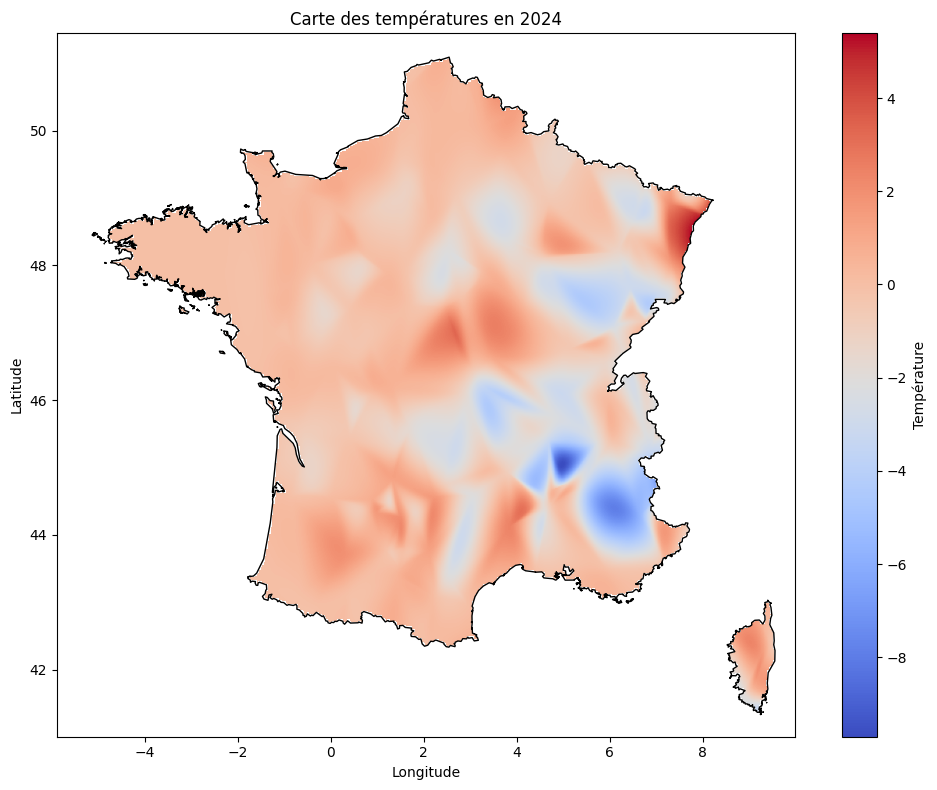

In [48]:
plot_temperature_map(result_diff_forecast_historical, interpolator, year=2024, method='triangulation', france_gdf=france_gdf)

## II/ETUDE PAR LES COMMUNES DE FRANCE   

Téléchargement du csv contenant l'ensemble des communes de France

In [49]:
commune_de_france=requests.get('https://www.data.gouv.fr/fr/datasets/r/dbe8a621-a9c4-4bc3-9cae-be1699c5ff25')
with open("communes_de_france.csv", "wb") as f:
    f.write(commune_de_france.content)

communes_de_france = pd.read_csv('communes_de_france.csv')
communes_de_france["latitude"].dropna(inplace=True)
communes_de_france["longitude"].dropna(inplace=True)

extrait_communes_de_france = communes_de_france.iloc[30001:32719] 


Téléchargement via l'API d'open-meteo des températures prédites en 2023 par heure pour les 2719 communes de France séléctionnées plus haut (Ne pas lancer extremement long, des exemples de requetes courtes seront données plus bas)

In [50]:
#data_frame_storage_past_forecast=pd.DataFrame(columns=['date','temperature_2m', 'latitude', "longitude"])
		# Setup the Open-Meteo API client with cache and retry on error
"""for i in range(len(extrait_communes_de_france)):
				cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
				retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
				openmeteo = openmeteo_requests.Client(session = retry_session)

				# Make sure all required weather variables are listed here
				# The order of variables in hourly or daily is important to assign them correctly below
				url = "https://historical-forecast-api.open-meteo.com/v1/forecast"
				params = {
					"latitude": extrait_communes_de_france["latitude"].iloc[i],
					"longitude": extrait_communes_de_france["longitude"].iloc[i],
					"start_date": "2023-01-01",
					"end_date": "2023-12-31",
					"hourly": "temperature_2m",
					"models": "meteofrance_seamless"
				}
				responses = openmeteo.weather_api(url, params=params)
								# Process first location. Add a for-loop for multiple locations or weather models
				response = responses[0]
				# Process hourly data. The order of variables needs to be the same as requested.
				hourly = response.Hourly()
				hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()

				hourly_data = {"date": pd.date_range(
					start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
					end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
					freq = pd.Timedelta(seconds = hourly.Interval()),
					inclusive = "left"
				)}
				hourly_data["temperature_2m"] = hourly_temperature_2m


				hourly_dataframe = pd.DataFrame(data = hourly_data)
				hourly_dataframe.dropna(inplace=True)
				hourly_dataframe["latitude"] = [extrait_communes_de_france["latitude"].iloc[i] for k in range(len(hourly_dataframe))]
				hourly_dataframe["longitude"] = [extrait_communes_de_france["longitude"].iloc[i] for k in range(len(hourly_dataframe))]
				data_frame_storage_past_forecast = pd.concat([data_frame_storage_past_forecast, hourly_dataframe], axis=0)
				time.sleep(0.5)
				print(i)
                
nom='température4_predites.csv'
data_frame_storage_past_forecast.to_csv(nom)
"""



'for i in range(len(extrait_communes_de_france)):\n\t\t\t\tcache_session = requests_cache.CachedSession(\'.cache\', expire_after = 3600)\n\t\t\t\tretry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)\n\t\t\t\topenmeteo = openmeteo_requests.Client(session = retry_session)\n\n\t\t\t\t# Make sure all required weather variables are listed here\n\t\t\t\t# The order of variables in hourly or daily is important to assign them correctly below\n\t\t\t\turl = "https://historical-forecast-api.open-meteo.com/v1/forecast"\n\t\t\t\tparams = {\n\t\t\t\t\t"latitude": extrait_communes_de_france["latitude"].iloc[i],\n\t\t\t\t\t"longitude": extrait_communes_de_france["longitude"].iloc[i],\n\t\t\t\t\t"start_date": "2023-01-01",\n\t\t\t\t\t"end_date": "2023-12-31",\n\t\t\t\t\t"hourly": "temperature_2m",\n\t\t\t\t\t"models": "meteofrance_seamless"\n\t\t\t\t}\n\t\t\t\tresponses = openmeteo.weather_api(url, params=params)\n\t\t\t\t\t\t\t\t# Process first location. Add a for-loop for multiple

Téléchargement des températures effectivement relevées en 2023 par heure pour les même communes de France

In [51]:
"""data_frame_storage_past_forecast=pd.DataFrame(columns=['date','temperature_2m', 'latitude', "longitude"])
# Setup the Open-Meteo API client with cache and retry on error
for i in range(len(extrait_communes_de_france)):
    cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
    retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
    openmeteo = openmeteo_requests.Client(session = retry_session)

    # Make sure all required weather variables are listed here
    # The order of variables in hourly or daily is important to assign them correctly below
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
			"latitude": extrait_communes_de_france["latitude"].iloc[i],
			"longitude": extrait_communes_de_france["longitude"].iloc[i],
			"start_date": "2023-01-01",
			"end_date": "2023-12-31",
			"hourly": "temperature_2m"
    }
    responses = openmeteo.weather_api(url, params=params)

    # Process first location. Add a for-loop for multiple locations or weather models
    response = responses[0]
    # Process hourly data. The order of variables needs to be the same as requested.
    hourly = response.Hourly()
    hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()

    hourly_data = {"date": pd.date_range(
        start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
        end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
        freq = pd.Timedelta(seconds = hourly.Interval()),
        inclusive = "left"
    )}
    hourly_data["temperature_2m"] = hourly_temperature_2m

    hourly_dataframe = pd.DataFrame(data = hourly_data)
    hourly_dataframe.dropna(inplace=True)
    hourly_dataframe["latitude"] = [extrait_communes_de_france["latitude"].iloc[i] for k in range(len(hourly_dataframe))]
    hourly_dataframe["longitude"] = [extrait_communes_de_france["longitude"].iloc[i] for k in range(len(hourly_dataframe))]
    data_frame_storage_past_forecast = pd.concat([data_frame_storage_past_forecast, hourly_dataframe], axis=0)
    time.sleep(0.5)
    print(i)
    
nom='température4_reelles.csv'
data_frame_storage_past_forecast.to_csv(nom)"""




'data_frame_storage_past_forecast=pd.DataFrame(columns=[\'date\',\'temperature_2m\', \'latitude\', "longitude"])\n# Setup the Open-Meteo API client with cache and retry on error\nfor i in range(len(extrait_communes_de_france)):\n    cache_session = requests_cache.CachedSession(\'.cache\', expire_after = -1)\n    retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)\n    openmeteo = openmeteo_requests.Client(session = retry_session)\n\n    # Make sure all required weather variables are listed here\n    # The order of variables in hourly or daily is important to assign them correctly below\n    url = "https://archive-api.open-meteo.com/v1/archive"\n    params = {\n\t\t\t"latitude": extrait_communes_de_france["latitude"].iloc[i],\n\t\t\t"longitude": extrait_communes_de_france["longitude"].iloc[i],\n\t\t\t"start_date": "2023-01-01",\n\t\t\t"end_date": "2023-12-31",\n\t\t\t"hourly": "temperature_2m"\n    }\n    responses = openmeteo.weather_api(url, params=params)\n\n    #

Petite précisions concernant les températures prédites : il s'agit des températures prédites à h-3 au point considéré. Ainsi la prédiction est effectuée 3h avant, ce qui est sensé assuré une meilleure précision des prédictions.

Préparation du fichier contenant les températures (le fichier final est sur le ssp cloud )

In [52]:
"""communes_de_france_temp_reelle4 = pd.read_csv('température4_reelles.csv')
communes_de_france_temp_predite4 = pd.read_csv('température4_predites.csv')"""

"communes_de_france_temp_reelle4 = pd.read_csv('température4_reelles.csv')\ncommunes_de_france_temp_predite4 = pd.read_csv('température4_predites.csv')"

In [53]:
"""communes_de_france_temp_reelle4 = communes_de_france_temp_reelle4.rename(columns={communes_de_france_temp_reelle4.columns[0]: 'compteur'})


température4_merged = pd.merge(communes_de_france_temp_predite4,communes_de_france_temp_reelle4, on=['date', 'longitude', 'latitude'])

new_name1 = {'temperature_2m_x' :  'temperature_2m', 'temperature_2m_y' : 'temperature_reelle_2m'}
température=température4_merged.rename(columns=new_name1)

print(température)"""


"communes_de_france_temp_reelle4 = communes_de_france_temp_reelle4.rename(columns={communes_de_france_temp_reelle4.columns[0]: 'compteur'})\n\n\ntempérature4_merged = pd.merge(communes_de_france_temp_predite4,communes_de_france_temp_reelle4, on=['date', 'longitude', 'latitude'])\n\nnew_name1 = {'temperature_2m_x' :  'temperature_2m', 'temperature_2m_y' : 'temperature_reelle_2m'}\ntempérature=température4_merged.rename(columns=new_name1)\n\nprint(température)"

In [54]:
"""température.to_csv('température4')"""

"température.to_csv('température4')"

## Télécharge le fichier depuis le SSP cloud (fichier assez volumineux, 2.6Go prend environ 6m)

In [55]:
FILE_PATH_S3 = "https://minio.lab.sspcloud.fr/sim2023/projet_python_data_science/température4.csv"
température4=requests.get(FILE_PATH_S3)
with open("température4.csv", "wb") as f:
    f.write(température4.content)

température = pd.read_csv('température4.csv')



Finalisation du data frame : on renomme les colonnes pour éviter les confusions : temperature_2m correspond à la température (en degré Celsius) à 2m du sol prédite par météo france, tandis que temperature_2m_reelle correspond à la température effectivement relevée à 2m du sol. Les données sont ici présentées heure par heure. On ajoute les colonnes d'erreur de prévisions : la colonne erreur peut-être posisitive ou négative, tandis que l'erreur absolue est la valeur absolue de l'erreur, justifions immédiatement l'usage de cette deuxième erreur.

In [56]:
new_name1 = {'temperature_2m_x' :  'temperature_2m', 'temperature_2m_y' : 'temperature_reelle_2m'}
température=température.rename(columns=new_name1)


In [57]:
#ajout des colonnes erreur et erreur absolue. Cette dernière est importante car le modèle se trompe presque autant en positif qu'en négatif, ainsi la moyenne de l'erreur est presque nuelle, ce qui ne nous renseigne pas beaucoup 
#environ 2m à executer

température["error"]=température["temperature_2m"]-température["temperature_reelle_2m"]
température["absolute_error"]=abs(température["error"])
température['date'] = pd.to_datetime(température['date']) # pour pouvoir facilement selectionner la date 
température = température.drop('Unnamed: 0', axis=1) 
température = température.drop('Unnamed: 0.1', axis=1) 
température

date  temperature_2m   latitude  longitude  \
0        2023-01-01 00:00:00+00:00         10.7935  47.620239   7.300485   
1        2023-01-01 01:00:00+00:00         10.5435  47.620239   7.300485   
2        2023-01-01 02:00:00+00:00         10.0435  47.620239   7.300485   
3        2023-01-01 03:00:00+00:00          9.2935  47.620239   7.300485   
4        2023-01-01 04:00:00+00:00          9.6935  47.620239   7.300485   
...                            ...             ...        ...        ...   
30012135 2023-12-31 19:00:00+00:00          7.2150  49.536044   1.274291   
30012136 2023-12-31 20:00:00+00:00          6.9650  49.536044   1.274291   
30012137 2023-12-31 21:00:00+00:00          6.6150  49.536044   1.274291   
30012138 2023-12-31 22:00:00+00:00          6.5150  49.536044   1.274291   
30012139 2023-12-31 23:00:00+00:00          6.5150  49.536044   1.274291   

          compteur  temperature_reelle_2m     error  absolute_error  
0                0               8.688001  2.105499        2.105499  
1                1               9.338000  1.205500        1.205500  
2                2               9.088000  0.955500        0.955500  
3                3              11.138001 -1.844501        1.844501  
4                4              11.988000 -2.294500        2.294500  
...            ...                    ...       ...             ...  
30012135      8755               6.643500  0.571500        0.571500  
30012136      8756               6.443500  0.521500        0.521500  
30012137      8757               6.293500  0.321500        0.321500  
30012138      8758               6.293500  0.221500        0.221500  
30012139      8759               6.193500  0.321500        0.321500  

[30012140 rows x 8 columns]

Le Data frame final, appelé température contient donc la position de chaque commune de l'échantillon (latitude et longitude), l'heure associée à la prédiction et au relevé de température, l'erreur de prévision et l'erreur absolue. 

## I) Statistiques descriptives 

In [58]:
température.describe()

temperature_2m      latitude     longitude      compteur  \
count    3.001214e+07  3.001214e+07  3.001214e+07  3.001214e+07   
mean     1.178816e+01  4.677136e+01  4.774628e+00  4.377007e+03   
std      8.239208e+00  1.044374e+00  2.078478e+00  2.527363e+03   
min     -2.455100e+01  4.512337e+01 -4.115236e-01  0.000000e+00   
25%      5.817500e+00  4.587460e+01  4.475200e+00  2.188000e+03   
50%      1.125650e+01  4.652006e+01  5.513290e+00  4.377000e+03   
75%      1.753250e+01  4.765055e+01  6.248441e+00  6.566000e+03   
max      4.224550e+01  4.998521e+01  7.584537e+00  8.759000e+03   

       temperature_reelle_2m         error  absolute_error  
count           3.001214e+07  3.001214e+07    3.001214e+07  
mean            1.153931e+01  2.488530e-01    1.223032e+00  
std             8.286451e+00  1.680122e+00    1.178530e+00  
min            -2.775550e+01 -1.524900e+01    0.000000e+00  
25%             5.717500e+00 -6.470001e-01    4.070020e-01  
50%             1.111600e+01  2.330000e-01    8.940010e-01  
75%             1.753250e+01  1.097000e+00    1.660001e+00  
max             4.221800e+01  1.743900e+01    1.743900e+01

Ainsi on remarque que la moyenne d'erreur sur l'échantillon de communes selectionnées est proche de 0 : en effet on s'attend à ce que le modèle se trompe autant en positif qu'en négatif, alors que l'écart absolue est en moyenne de 1.22°C.
le modèle s'est au maximum trompé de 17,44°C ! 
Tracons pour mieux visualiser la répartitions des erreurs du modèle.

C:\Users\tsang\AppData\Local\Temp\ipykernel_11176\1642820630.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(température['error'])


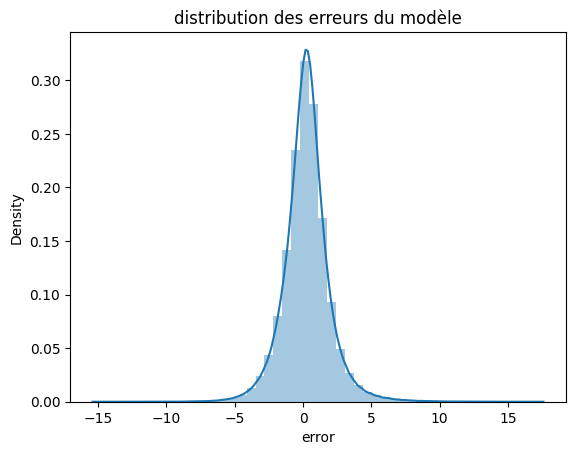

In [59]:
#environ 1m30s à executer

plt.figure()
sns.distplot(température['error'])
plt.title("distribution des erreurs du modèle")
plt.show()

On observe  ce qui ressemble à une belle Gaussienne (presque centrée) dans la distribution des erreurs du modèle. Cependant, le nombre d'erreurs assez importantes est assez conséquent. Etudions la répartion des erreurs dites inacceptable (celle dont l'erreur est supérieur à 10°C, un tel écart pourrait nous faire prendre froid assez facilement par exemple ! d'où l'inacceptabilité de l'erreur)

In [60]:
température['date'] = pd.to_datetime(température['date']) # pour pouvoir facilement selectionner la date 

In [61]:
important_error=température[température["absolute_error"]>=10] # on regarde où et quand ont eu lieu les ecarts de prévisions importants ie supérieurs à 7°C 

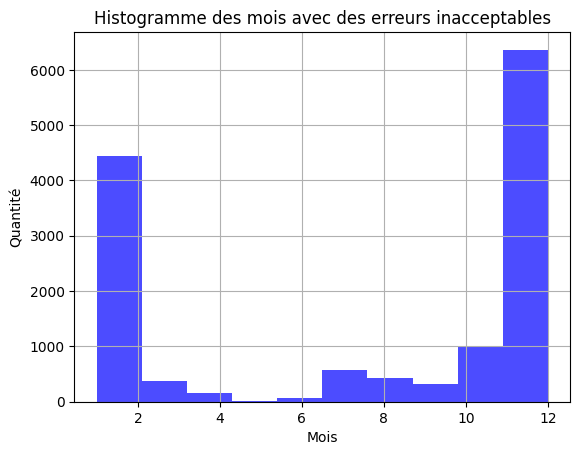

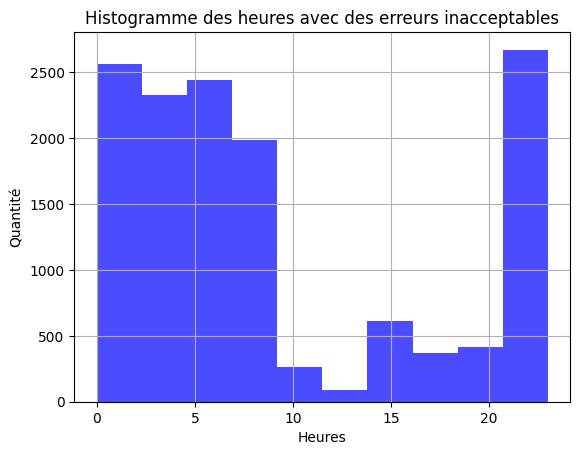

In [62]:
plt.hist(important_error["date"].dt.month, alpha=0.7, color='b')

plt.xlabel('Mois')
plt.ylabel('Quantité')
plt.title('Histogramme des mois avec des erreurs inacceptables')
plt.grid(True)


plt.show()


plt.hist(important_error["date"].dt.hour, alpha=0.7, color='b')

# Customize the plot
plt.xlabel('Heures')
plt.ylabel('Quantité')
plt.title('Histogramme des heures avec des erreurs inacceptables')
plt.grid(True)


plt.show()

On remarque que le modèle semble se tromper particulièrement en hiver, fin automne et début printemps, avec un nombre d'erreur minimal en mai. Et principalement durant la nuit. Ici on ne concidère que le nombre d'erreur inacceptable.

Regardons maintenant quelles sont les communes de l'échantillon, cela nous premettra peut-être de mieux comprendre d'où proviennent ces erreurs.

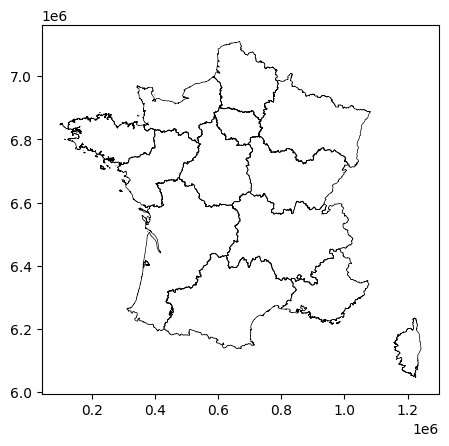

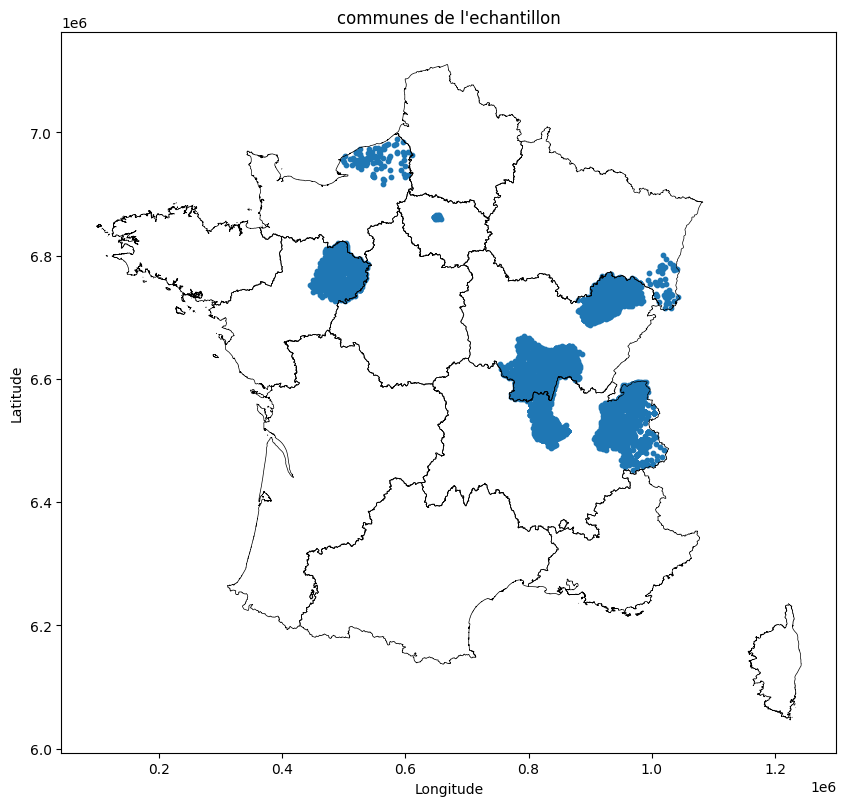

In [63]:
from cartiflette import carti_download

france = carti_download(
    values=["France"],
    crs=4326,
    borders="REGION",
    vectorfile_format="geojson",
    simplification=50,
    filter_by="FRANCE_ENTIERE",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022,
)
france = france.loc[france["INSEE_REG"] > 10]
france_2154 = france.to_crs(2154)
ax1 = france_2154.boundary.plot(edgecolor="k", linewidth=0.5)
# Convertir le DataFrame pandas en GeoDataFrame avec la projection EPSG:4326

liste_commune= température[température["compteur"]==1]

geometry = [Point(xy) for xy in zip(liste_commune["longitude"], liste_commune["latitude"])]
geo_result = gpd.GeoDataFrame(liste_commune, geometry=geometry, crs="EPSG:4326")

# Reprojections des points en Lambert-93 (pour correspondre à france_2154)
geo_result_2154 = geo_result.to_crs(2154)

# Afficher la carte de la France et les communes de l'échantillon
fig, ax = plt.subplots(figsize=(10, 10))

# Afficher les frontières de la France métropolitaine
france_2154.boundary.plot(ax=ax, edgecolor="k", linewidth=0.5)



geo_result_2154.plot(ax=ax, markersize=10, legend=True)

# Afficher la carte avec les légendes
plt.title("communes de l'echantillon")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

Il y a Paris, les communes de la Sarte, les communes de Savoie, de la Seine maritime, du Rhone... (Les communes sont rangées dans l'odre alphabétique des déprtements). Mais Est ce que les erreurs inacceptables sont réparties sur l'ensemble de ces communes ? 

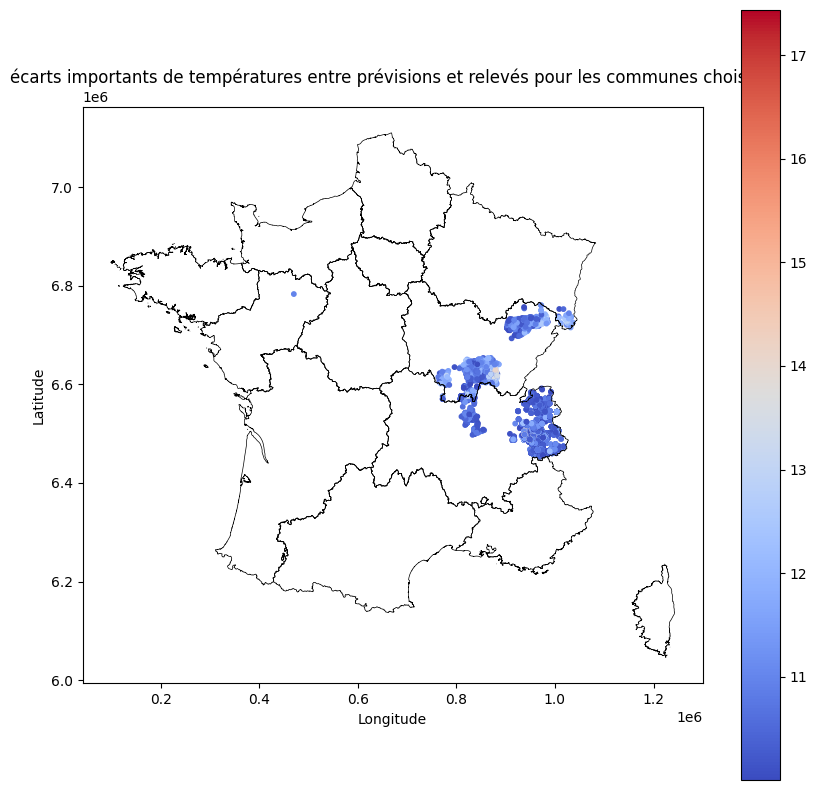

In [64]:
# on utilise le même code que précedement mais adapté pour affichier un dégrader de couleur associé aux erreurs de prédictions
geometry = [Point(xy) for xy in zip(important_error["longitude"], important_error["latitude"])]
geo_result = gpd.GeoDataFrame(important_error, geometry=geometry, crs="EPSG:4326")

geo_result_2154 = geo_result.to_crs(2154)

fig, ax = plt.subplots(figsize=(10, 10))

france_2154.boundary.plot(ax=ax, edgecolor="k", linewidth=0.5)

geo_result_2154.plot(ax=ax, column="absolute_error", cmap="coolwarm", markersize=10, legend=True)

plt.title("écarts importants de températures entre prévisions et relevés pour les communes choisies ")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

On voit ainsi que la répartition des erreurs inacceptables se situe plutot dans les régions montagneuses de l'echantillon. Pour essayer de comprendre d'où proviennent les erreurs focalisons nous sur une ville ayant de nombreuses erreurs inacceptable : 

In [65]:
#on cherche le couple de coordonnées qui reviennent les plus souvent dans le data frame qui contient l'ensemble des erreurs inacceptables 

def compte_couple(data_frame):
    dico=dict()
    for i in range(len(data_frame)):
        couple=(data_frame["latitude"].iloc[i],data_frame["longitude"].iloc[i])
        if couple in dico:
            dico[couple]+=1
        else:
            dico[couple]=1
    max_key = max(dico, key=dico.get)

    return( max_key)

compte_couple(important_error)

(np.float64(45.5274218608), np.float64(6.46078348062))

On a donc trouvé la commune avec le plus d'erreur inacceptable de l'échantillon en 2023, il s'agit de La Léchère 73260 en Savoie, Auvergne-Rhone-Alpes qui compte 2601 habitants (source : https://politique.pappers.fr/commune/lechere-73260#populationLa%20L%C3%A9ch%C3%A8re) la commune fait 134,54km² de superficie (ce qui est plus grand que Paris) et s'élève à une altitude comprise entre 411m et 2829m (Grand pic de la Lauzière ). Commencons par décrire les erreurs de prévisions que l'on observe dans cette ville, ie retrouve-t-on les mêmes résultats que précedement :  


In [66]:
#séléction de la ville 
latitude_La_Lechere = 45.5274218608
longitude_La_Lechere = 6.46078348062
tolerance = 1e-6  # Tolérance, pour éviter les problèmes d'arrondis

La_Lechere = température[
    (np.abs(température["latitude"] - latitude_La_Lechere) < tolerance) &
    (np.abs(température["longitude"] - longitude_La_Lechere) < tolerance)
]
La_Lechere=La_Lechere.drop_duplicates(subset=['date'])

In [67]:
La_Lechere

date  temperature_2m   latitude  longitude  \
23008140 2023-01-01 00:00:00+00:00        8.688001  45.527422   6.460783   
23008146 2023-01-01 01:00:00+00:00        7.938000  45.527422   6.460783   
23008152 2023-01-01 02:00:00+00:00        7.988000  45.527422   6.460783   
23008158 2023-01-01 03:00:00+00:00        8.138001  45.527422   6.460783   
23008164 2023-01-01 04:00:00+00:00        7.538000  45.527422   6.460783   
...                            ...             ...        ...        ...   
23060640 2023-12-31 19:00:00+00:00        2.197000  45.527422   6.460783   
23060646 2023-12-31 20:00:00+00:00        2.197000  45.527422   6.460783   
23060652 2023-12-31 21:00:00+00:00        2.347000  45.527422   6.460783   
23060658 2023-12-31 22:00:00+00:00        2.397000  45.527422   6.460783   
23060664 2023-12-31 23:00:00+00:00        2.647000  45.527422   6.460783   

          compteur  temperature_reelle_2m     error  absolute_error  
23008140         0                  6.563  2.125001        2.125001  
23008146         1                  6.363  1.575000        1.575000  
23008152         2                  5.663  2.325000        2.325000  
23008158         3                  5.163  2.975001        2.975001  
23008164         4                  4.863  2.675000        2.675000  
...            ...                    ...       ...             ...  
23060640      8755                  0.463  1.734000        1.734000  
23060646      8756                  0.763  1.434000        1.434000  
23060652      8757                  0.513  1.834000        1.834000  
23060658      8758                 -0.137  2.534000        2.534000  
23060664      8759                 -0.387  3.034000        3.034000  

[8755 rows x 8 columns]

On a le même type de data frame que pour température, mais restreint à une seule commune. 

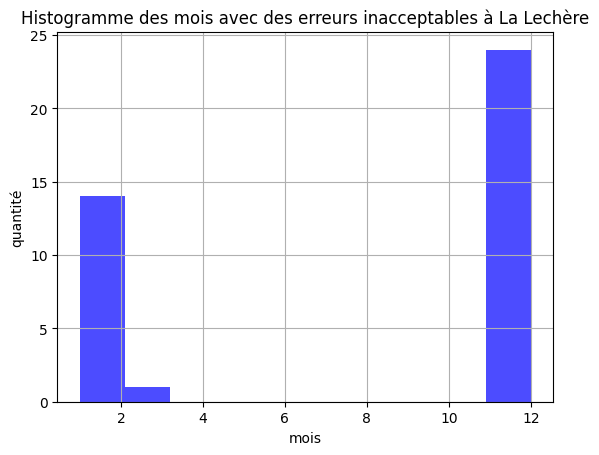

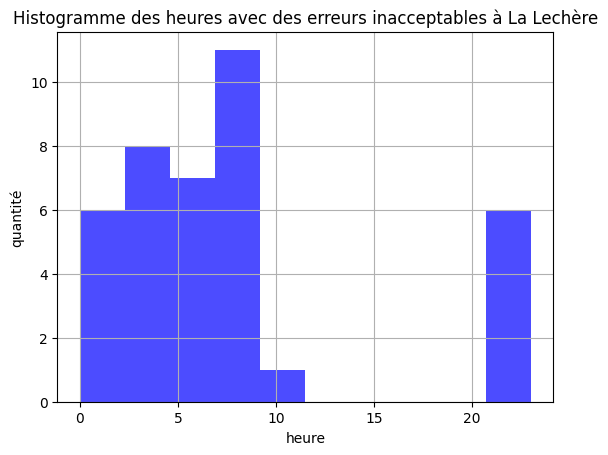

In [68]:
#on trace les histogrammes des erreurs de prédictions dans la ville, pour vois si l'on retrouve les même tendances qu'au dessus

La_Lechere_inacceptable= La_Lechere[La_Lechere["absolute_error"]>=10]

plt.hist(La_Lechere_inacceptable["date"].dt.month, alpha=0.7, color='b')

plt.xlabel('mois')
plt.ylabel('quantité')
plt.title('Histogramme des mois avec des erreurs inacceptables à La Lechère')
plt.grid(True)
plt.show()


plt.hist(La_Lechere_inacceptable["date"].dt.hour, alpha=0.7, color='b')

plt.xlabel('heure')
plt.ylabel('quantité')
plt.title('Histogramme des heures avec des erreurs inacceptables à La Lechère')
plt.grid(True)
plt.show()

On retrouve le même biais d'erreur qui semble lié au mois choisi : décembre et janvier semble les mois les moins bien prévisibles. En ce qui concerne les heures on trouve que la nuit est bien moins prédite que le reste de la journée



Focalisons nous sur 18h  : c'est l'heure ou les habitants sortent de l'école ou du travail et ont besoin de prévisions fiables

In [69]:
La_Lechere_18h = La_Lechere[La_Lechere["date"].dt.hour == 18] #étude à 18h 

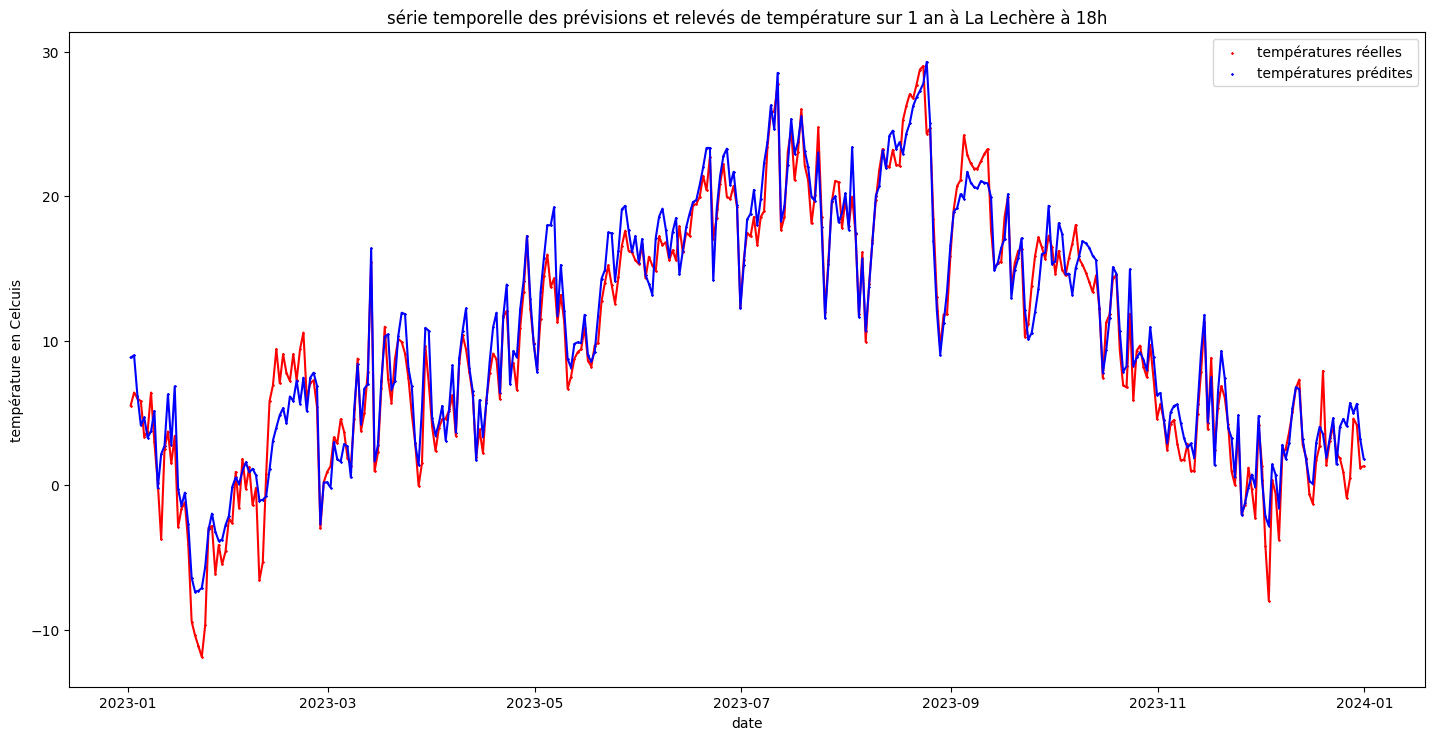

In [70]:
x = La_Lechere_18h["date"]
temperatures_reelles = La_Lechere_18h["temperature_reelle_2m"]
temperatures_predites = La_Lechere_18h["temperature_2m"]

fig = plt.figure(figsize=(17.5,8.5))

plt.scatter(x, temperatures_reelles, c='r', marker='X', s=0.5, label= "températures réelles") # température réelle 
plt.scatter(x, temperatures_predites, c='b', marker='X', s=0.5, label= "températures prédites")  # température prédite par le modèle 
plt.legend()
plt.xlabel('date')
plt.ylabel('température en Celcuis')
plt.title("série temporelle des prévisions et relevés de température sur 1 an à La Lechère à 18h")

plt.plot(x, temperatures_reelles, color='r')
plt.plot(x, temperatures_predites, color='b')

Hormis en début et fin d'année, la courbe de prédiction approxime bien la courbe des températures relevées, essayons de voir plus en détail les écarts entre ces deux courbes

<function matplotlib.pyplot.show(close=None, block=None)>

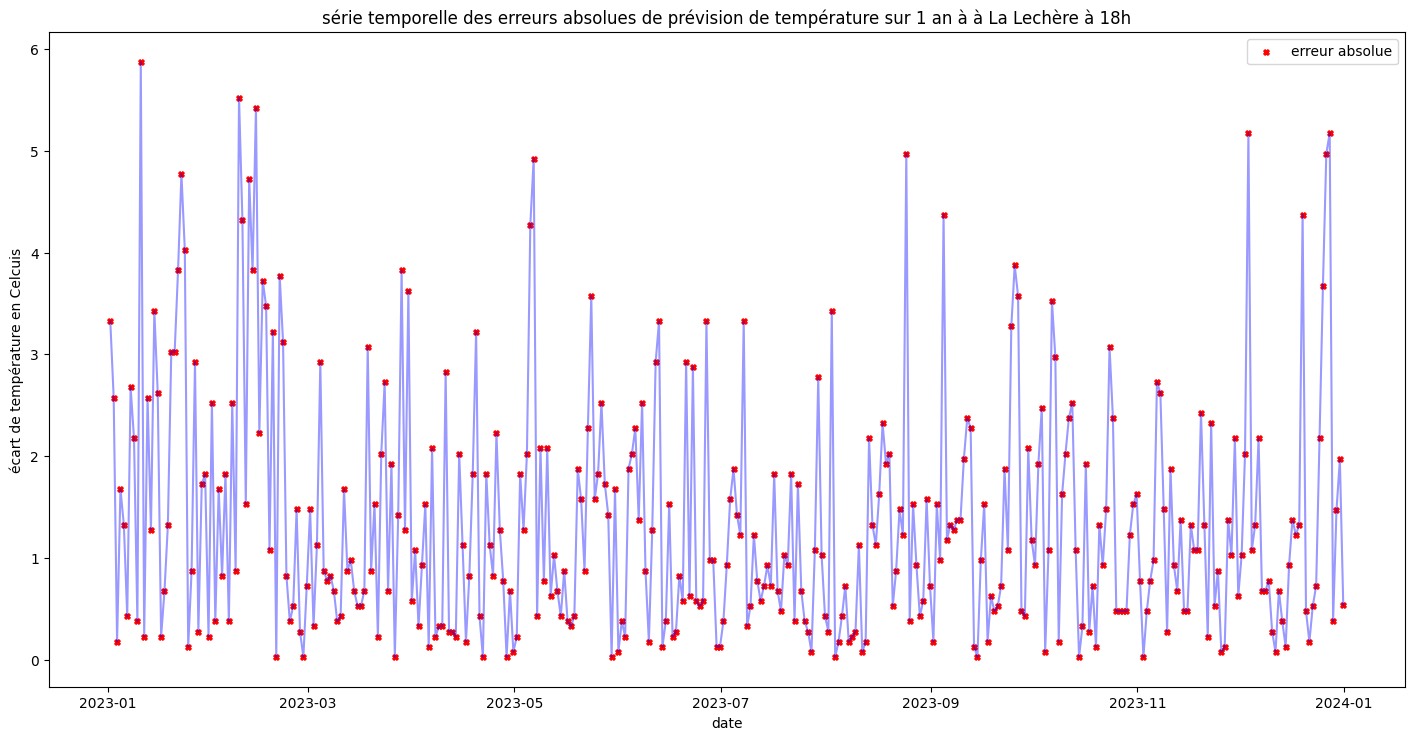

In [71]:
x = La_Lechere_18h["date"]
y1 = La_Lechere_18h["absolute_error"]


fig = plt.figure(figsize=(17.5,8.5))

# Scatter plot the points
plt.scatter(x, y1, c='r', marker='X', s=15, label= "erreur absolue") # température réelle 
plt.legend()

# Set labels
plt.xlabel('date')
plt.ylabel('écart de température en Celcuis')
plt.title("série temporelle des erreurs absolues de prévision de température sur 1 an à à La Lechère à 18h")

plt.plot(x, y1, color='b', alpha=0.4)


plt.show

A 18h le modèle semble se tromper d'au moins quelques degrés chaque jour, mais on peut mieux appricier la qualité des prédicitons d'été par rapport à celle d'hiver

## II) Etude des sources d'erreurs 

Essayons de voir si la présence ou non d'autres facteurs météorologique pourraient expliquer ces écarts. En effet La Lechere est une ville de montagne, où de nombreux autres phénomènes météorologiques peuvent survenir telle que les chutes abondantes de neige etc.

In [72]:
#On requete de nouvelles données telles que les précipitations, la profondeur de la neige et la couverture nuageuse

cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": latitude_La_Lechere,
	"longitude": longitude_La_Lechere,
	"start_date": "2023-01-01",
	"end_date": "2023-12-31",
	"hourly": ["temperature_2m", "precipitation", "snow_depth", "surface_pressure", "cloud_cover", "cloud_cover_low", "cloud_cover_mid", "cloud_cover_high", "wind_speed_10m"]
}
responses = openmeteo.weather_api(url, params=params)

# Process first location
response = responses[0]


# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_precipitation = hourly.Variables(1).ValuesAsNumpy()
hourly_snow_depth = hourly.Variables(2).ValuesAsNumpy()
hourly_surface_pressure = hourly.Variables(3).ValuesAsNumpy()
hourly_cloud_cover = hourly.Variables(4).ValuesAsNumpy()
hourly_cloud_cover_low = hourly.Variables(5).ValuesAsNumpy()
hourly_cloud_cover_mid = hourly.Variables(6).ValuesAsNumpy()
hourly_cloud_cover_high = hourly.Variables(7).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(8).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["precipitation"] = hourly_precipitation
hourly_data["snow_depth"] = hourly_snow_depth
hourly_data["surface_pressure"] = hourly_surface_pressure
hourly_data["cloud_cover"] = hourly_cloud_cover
hourly_data["cloud_cover_low"] = hourly_cloud_cover_low
hourly_data["cloud_cover_mid"] = hourly_cloud_cover_mid
hourly_data["cloud_cover_high"] = hourly_cloud_cover_high
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m

La_Lechere_past_data = pd.DataFrame(data = hourly_data)



Il y a  5 lignes de trop dans les données historique : on les identifie puis on les retire 


In [73]:
print(La_Lechere_past_data.tail(20))
print(La_Lechere.tail(20))

                          date  temperature_2m  precipitation  snow_depth  \
8740 2023-12-31 04:00:00+00:00          -1.387            0.0        0.74   
8741 2023-12-31 05:00:00+00:00          -0.187            0.0        0.74   
8742 2023-12-31 06:00:00+00:00          -0.287            0.0        0.74   
8743 2023-12-31 07:00:00+00:00           0.063            0.0        0.73   
8744 2023-12-31 08:00:00+00:00           0.713            0.0        0.73   
8745 2023-12-31 09:00:00+00:00           2.413            0.0        0.73   
8746 2023-12-31 10:00:00+00:00           4.463            0.0        0.73   
8747 2023-12-31 11:00:00+00:00           6.413            0.0        0.73   
8748 2023-12-31 12:00:00+00:00           6.563            0.0        0.73   
8749 2023-12-31 13:00:00+00:00           5.363            0.0        0.73   
8750 2023-12-31 14:00:00+00:00           3.763            1.2        0.74   
8751 2023-12-31 15:00:00+00:00           2.313            4.9        0.74   

il y a les 5 heures manquantes dans les données prévisionnelles de 7h à 12 le 31 décembre 2023. on retire ces données du data frame historique :

In [74]:
La_Lechere_past_data['date'] = pd.to_datetime(La_Lechere_past_data['date'])

In [75]:
La_Lechere_past_data = La_Lechere_past_data.drop(La_Lechere_past_data.index[[8743,8744,8745,8746,8747]])

In [76]:
La_Lechere_past_data

date  temperature_2m  precipitation  snow_depth  \
0    2023-01-01 00:00:00+00:00           6.563            0.0        0.28   
1    2023-01-01 01:00:00+00:00           6.363            0.0        0.28   
2    2023-01-01 02:00:00+00:00           5.663            0.0        0.28   
3    2023-01-01 03:00:00+00:00           5.163            0.0        0.28   
4    2023-01-01 04:00:00+00:00           4.863            0.0        0.28   
...                        ...             ...            ...         ...   
8755 2023-12-31 19:00:00+00:00           0.463            0.1        0.79   
8756 2023-12-31 20:00:00+00:00           0.763            0.2        0.80   
8757 2023-12-31 21:00:00+00:00           0.513            2.5        0.80   
8758 2023-12-31 22:00:00+00:00          -0.137            0.5        0.80   
8759 2023-12-31 23:00:00+00:00          -0.387            0.1        0.81   

      surface_pressure  cloud_cover  cloud_cover_low  cloud_cover_mid  \
0           917.387268         26.0             24.0             33.0   
1           917.225952         28.0             22.0             25.0   
2           917.420593         39.0             33.0             26.0   
3           917.775940         46.0             18.0             28.0   
4           917.934998         42.0             40.0             31.0   
...                ...          ...              ...              ...   
8755        905.772034        100.0             36.0            100.0   
8756        905.883423         96.0              2.0             96.0   
8757        907.308594         97.0             87.0             90.0   
8758        908.137878         95.0             94.0             25.0   
8759        908.401428         80.0             79.0              6.0   

      cloud_cover_high  wind_speed_10m  
0                  0.0        7.993297  
1                  0.0        4.896530  
2                  0.0        4.610250  
3                 17.0        4.394360  
4                  0.0        4.693826  
...                ...             ...  
8755               0.0        3.600000  
8756               0.0        3.096837  
8757               0.0        3.976330  
8758               0.0        2.276840  
8759               0.0        3.706427  

[8755 rows x 10 columns]

Dans le data frame ci dessus, nous avons toujours la température réelle prise à 2m du sol, en degré. Nous ajoutons l'information sur les précipitations (en mm), la profondeur de la neige (en m), la couverture nuageuse (en %) à différentes altitudes, la pression relevée à la surface du sol (en hPa), et enfin la vitesse du vent à 10m du sol (en km/h). 

On calcul les coefficients de correlation de Pearson pour établir un lien ou non entre l'erreur absolue de prévision et d'autres facteurs météorologiques

In [77]:
x = La_Lechere["absolute_error"]
surface_pressure = La_Lechere_past_data["surface_pressure"]

corr_coeff, p_value = pearsonr(x, surface_pressure)
print(f"Coefficient de Correlation de Pearson entre l'erreur absolue et la pression de surface : {corr_coeff}")
print(f"p-value: {p_value}")

Coefficient de Correlation de Pearson entre l'erreur absolue et la pression de surface : 0.050760346065636834
p-value: 2.014769827202251e-06


In [78]:
precipitation = La_Lechere_past_data["precipitation"]

corr_coeff, p_value = pearsonr(x, precipitation)
print(f"Coefficient de Correlation de Pearsonentre l'erreur absolue et les précipations : {corr_coeff}")
print(f"p-value: {p_value}")

Coefficient de Correlation de Pearsonentre l'erreur absolue et les précipations : -0.11363474140671714
p-value: 1.4738560042453538e-26


Rien de très concluant jusque là, les coefficients de correlation sont assez faibles et les p-value sont très faibles ce qui nous indique que les liens entre ces variables sont effectivement très faibles. 

In [79]:
cloud_cover = La_Lechere_past_data["cloud_cover"]

corr_coeff, p_value = pearsonr(x, cloud_cover)
print(f"Coefficient de Correlation de Pearson entre l'erreur absolue et la couverture nuageuse : {corr_coeff}")
print(f"p-value: {p_value}")

Coefficient de Correlation de Pearson entre l'erreur absolue et la couverture nuageuse : -0.20854100932181707
p-value: 1.2575390368749227e-86


In [80]:
snow_depth = La_Lechere_past_data["snow_depth"]

corr_coeff, p_value = pearsonr(x, snow_depth)
print(f"Coefficient de Correlation de Pearson entre l'erreur absolue et la profondeur de la neige : {corr_coeff}")
print(f"p-value: {p_value}")

Coefficient de Correlation de Pearson entre l'erreur absolue et la profondeur de la neige : 0.2850548533967957
p-value: 2.4865830857327962e-163


Pour l'épaisseur de neige et la couverture nuageuse, on obtient de meilleurs coefficient de correlation, avec des p-value extremement faible : 0.29 et -0.20 respectivement pour les coefficients de correlation. Les erreurs de prévisions seraient donc un peu corrélées à la présence de neige sur le sol, étudions cela plus en détail. 

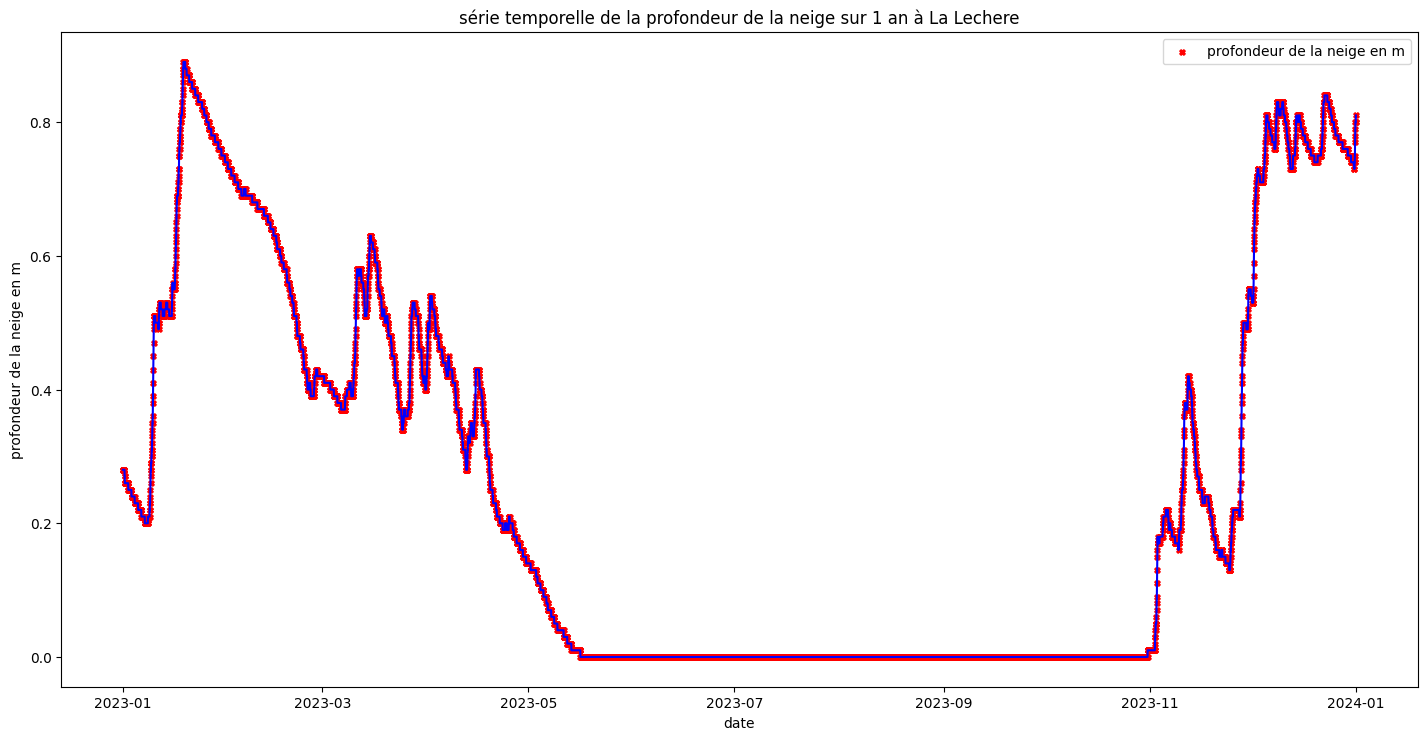

In [81]:
La_Lechere_past_data['date'] = pd.to_datetime(La_Lechere_past_data['date'])
x = La_Lechere_past_data["date"]
y1 = La_Lechere_past_data["snow_depth"]


fig = plt.figure(figsize=(17.5,8.5))

# Scatter plot the points
plt.scatter(x, y1, c='r', marker='X', s=15, label= "profondeur de la neige en m")  
plt.legend()

# Set labels
plt.xlabel('date')
plt.ylabel('profondeur de la neige en m')
plt.title("série temporelle de la profondeur de la neige sur 1 an à La Lechere")

plt.plot(x, y1, color='b')

Cepedant, comme ce graphique nous le rappel, il n'y a pas de neige l'été ! mais quand même des erreurs de prévisions ! Superposons ce courbes pour mieux voir, en retirant les valeurs lors de la fin du printemps, de l'été et du début de l'automne (par continuité du tracé une ligne horizontale apparait, il ne faut pas en tenir compte).

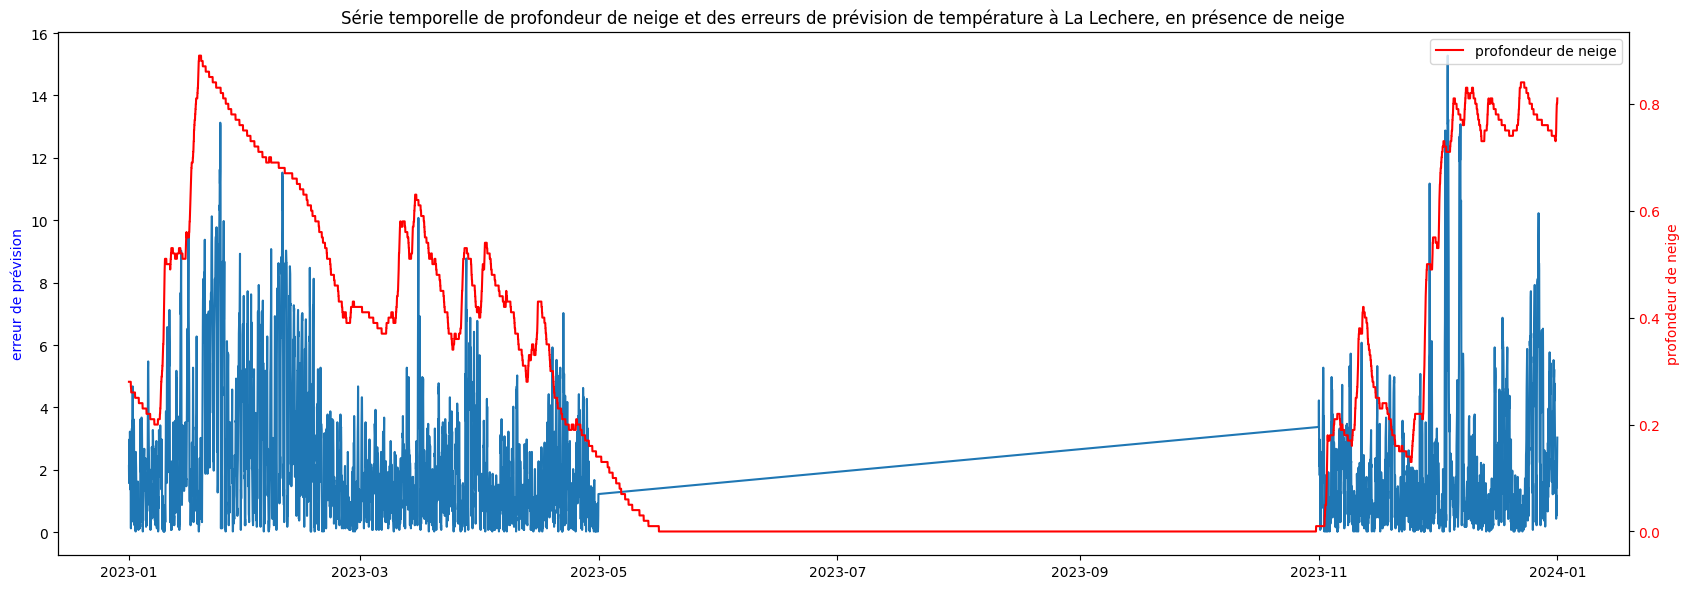

In [82]:
La_Lechere_past_data['date'] = pd.to_datetime(La_Lechere_past_data['date'])
x = La_Lechere_past_data["date"]
y1 = La_Lechere_past_data["snow_depth"]


fig, ax1 = plt.subplots(figsize=(17, 6))
plt.title('Série temporelle de profondeur de neige et des erreurs de prévision de température à La Lechere, en présence de neige')


dates = La_Lechere_past_data["date"]
values = np.array(La_Lechere["absolute_error"])
df = pd.DataFrame({'value': values}, index=dates)


month_without_snow = [5,6, 7, 8,9,10]  #mai, juin, juillet, aout, septembre et octobre

# Création d'un Booléen pour les mois avec ou sans neige
no_snow = ~df.index.month.isin(month_without_snow)


ax1.plot(df.index[no_snow], df['value'][no_snow])
ax1.plot(df.index[~no_snow], df['value'][~no_snow],linestyle='', alpha = 0.001) 
ax1.set_ylabel('erreur de prévision', color='b')


# Création d'un second axe d'ordonné pour plus de lisibilité
ax2 = ax1.twinx()


ax2.plot(x, y1, 'r-', label='profondeur de neige')
ax2.set_ylabel('profondeur de neige', color='r') 
ax2.tick_params(axis='y', labelcolor='r') 


lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper right")


fig.tight_layout()


plt.show()



les variations de profondeur de neige semblent en hiver mieux expliquer la présence d'erreurs de prévisions. Mais est ce que retirer les d'été valeurs améliore réellement la corrélation entre ces variables ? 

In [83]:
dates = La_Lechere_past_data["date"]
values_error = np.array(La_Lechere["absolute_error"])
values_snow = np.array(La_Lechere_past_data["snow_depth"])

df = pd.DataFrame({'value_snow': values_snow, 'value_error' : values_error}, index=dates)

summer_months = [5,6, 7, 8,9,10] 
not_summer = ~df.index.month.isin(summer_months)
df_2 = df[not_summer]

snow_depth_winter_only = df_2["value_snow"]
date_only_winter = df_2["value_error"]

corr_coeff, p_value = pearsonr(date_only_winter, snow_depth_winter_only)
print(f"Pearson Correlation Coefficient entre l'erreur absolue et la profondeur de la neige en hiver: {corr_coeff}")
print(f"p-value: {p_value}")




Pearson Correlation Coefficient entre l'erreur absolue et la profondeur de la neige en hiver: 0.3180030581763714
p-value: 1.4995108742685257e-102


Le coefficient de corrélation augmente légèrement, mais cela ne semble pas être concluant. Ainsi l'ajout d'information via de nouvelles variables météorologiques ne nous aide pas à mieux comprendre d'où proviennent les erreurs de prédiction de température. 

## III) Prédiction sur les prévisions 

Essayons à présent de prédire la température réelle à partir de la prévision faire par météo France.
Commençons par approximer par une fonction polynomiale l'ensemble de nos données, puis nous utiliserons un algorithme de random forest pour prédire la température réelle à une heure donnée à partir de la prédiction initiale effectuée par météo France

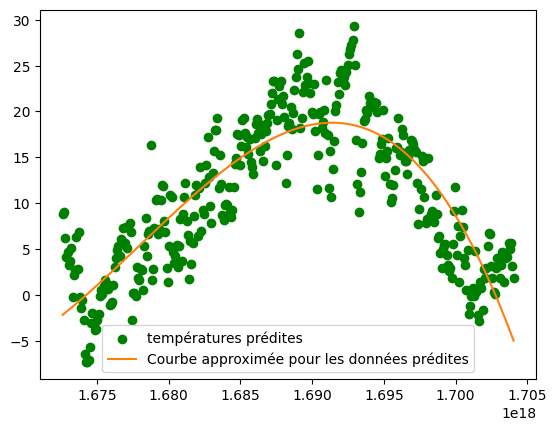

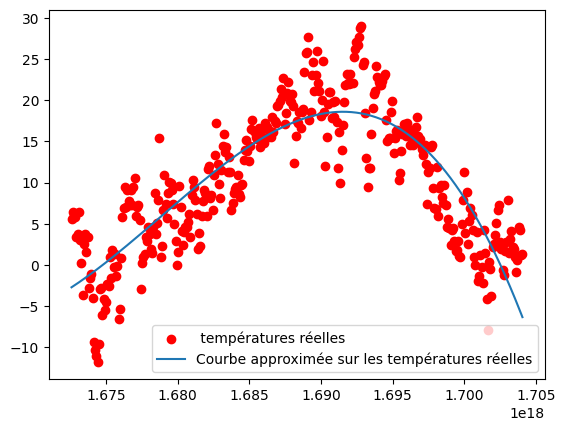

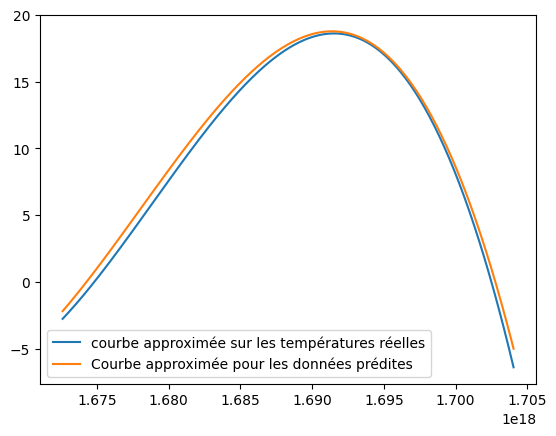

In [84]:
time = La_Lechere_18h["date"].values.astype(float) # on doit convertir les date en nombre 
real_values = La_Lechere_18h["temperature_reelle_2m"].values
values=La_Lechere_18h["temperature_2m"].values

def polynomial(x, a, b, c, d):
    return a * x**4 + b * x**3 + c*x**2 + d*x 


# Fit the curve
popt, pcov = curve_fit(polynomial, time, values )
plt.scatter(time, values, label='températures prédites', c="g")
plt.plot(time, polynomial(time, *popt), label='Courbe approximée pour les données prédites', c="C1")
plt.legend()
plt.show()

popt1, pcov1 = curve_fit(polynomial, time, real_values )
plt.scatter(time, real_values, label=' températures réelles' , c="r")
plt.plot(time, polynomial(time, *popt1), label='Courbe approximée sur les températures réelles')
plt.legend()
plt.show()

#superposision des deux corubes précédentes pour apprécier les écarts entre celles ci
plt.plot(time, polynomial(time, *popt1), label='courbe approximée sur les températures réelles')
plt.plot(time, polynomial(time, *popt), label='Courbe approximée pour les données prédites')
plt.legend()
plt.show()


Avec le curve fitting des données on retrouve bien l'accentuation des écarts de températures entre prédictions et réalité en hiver : les températures réelles sont ici approché par un polynome dont les ordonnées sont plus faible que celles du polynome pour les valeurs prédites. 

Utilisons désormais un algorithme de Random Forest pour prédire la température réelle à La Lechere en fonction de la température prévue par Météo France.L'algorithme de random forest est ici utilisé comme un filtre correcteur des prévisions de météo France.

Préparations des jeux de données d'entrainement et de test, nous évaluons ensuite le modèle avec le calcul du R2

In [85]:
dates = La_Lechere["date"]
temperatures_reelles_La_Lechere = np.array(La_Lechere["temperature_reelle_2m"])
temperatures_predites_La_Lechere = np.array(La_Lechere["temperature_2m"])
df = pd.DataFrame({'real_temp': temperatures_reelles_La_Lechere, 'prediction': temperatures_predites_La_Lechere}, index=dates)


X = df[['prediction']]  
y = df['real_temp']     
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=100)

rf_model = RandomForestRegressor(n_estimators=200, random_state=100, max_depth=7) #j'ai mis un peu aléatoirement je le reconnais
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R²: {r2}")



Mean Squared Error: 5.341984660683371
R²: 0.9313998129344234


Nous avons un R² très proche de 1, signe d'un modèle bien entrainé ! 

On va maintenant essayer le modèle avec de nouvelles données pour cela on requete encore une fois auprès de open-meteo, toujours dans la ville de La Lechere, mais pour l'année 2024.

In [86]:
#températures prédites par météo France

cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# The order of variables in hourly or daily is important to assign them correctly below
url = "https://historical-forecast-api.open-meteo.com/v1/forecast"
params = {
	"latitude": latitude_La_Lechere,
	"longitude": longitude_La_Lechere,
	"start_date": "2024-01-01",
	"end_date": "2024-12-25",
	"hourly": "temperature_2m",
	"models": "meteofrance_seamless"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["temperature_2m"] = hourly_temperature_2m

prevision_noel_la_lechere= pd.DataFrame(data = hourly_data)


In [87]:
#températures réelles

cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": latitude_La_Lechere,
	"longitude": longitude_La_Lechere,
	"start_date": "2024-01-01",
	"end_date": "2024-12-25",
	"hourly": "temperature_2m"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["temperature_2m_reelle"] = hourly_temperature_2m

temperature_reelle_noel_la_lechere = pd.DataFrame(data = hourly_data)


Applications du modèles aux nouvelles données ie on applique le modèles au prévisions de températures par heure de l'année 2024 (jusqu'au 25 décembre), que l'on va confronter avec les températures effectivement relevées

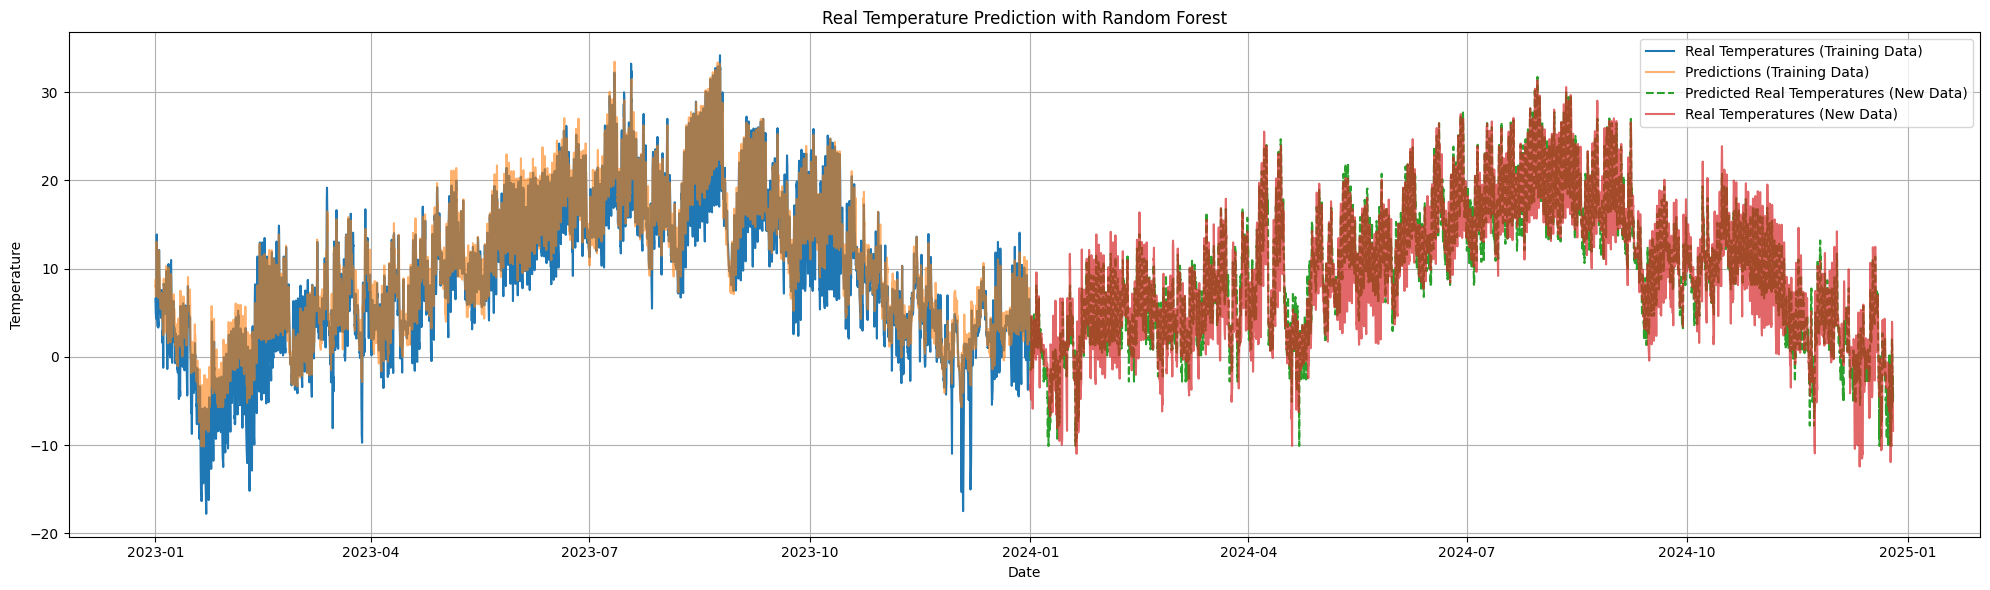

In [88]:
new_dates = temperature_reelle_noel_la_lechere["date"] # nous sommes désormais en 2024
new_predictions = np.array(prevision_noel_la_lechere["temperature_2m"]) # prévisions pour chaque heure de la température en 2024 
new_real_temp = np.array(temperature_reelle_noel_la_lechere["temperature_2m_reelle"]) #températures réelles par ehure à La Lechère en 2024

new_df = pd.DataFrame({'prediction': new_predictions}, index=new_dates)  # création des data frame qui ne contiennet que les données qui nous interessent
new_df_real = pd.DataFrame({'real_temp' :new_real_temp}, index= new_dates)
new_X = new_df[['prediction']]
new_real_temps_predicted = rf_model.predict(new_X) #application du modèle aux températures prévues

new_df['predicted_real_temp'] = new_real_temps_predicted #températures réelles prévues par le modèle de random forest

#on trace tou ca : On trace les deux années de données 
plt.figure(figsize=(20, 6))
plt.plot(df.index, df['real_temp'], label='Real Temperatures (Training Data)')
plt.plot(df.index, df['prediction'], label='Predictions (Training Data)', alpha=0.6)
plt.plot(new_df.index, new_df['predicted_real_temp'], label='Predicted Real Temperatures (New Data)', linestyle='--')
plt.plot(new_df.index, new_df_real['real_temp'],label = 'Real Temperatures (New Data)', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Real Temperature Prediction with Random Forest')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Lecture : à Gauche se trouve les données d'entrainement année 2023 et à droites de nouvelles données (2024) sur lesquelles on a appliqué la prédiction par random forest, ce graphique est assez joli, mais ne permet pas in fine d'évaluer le modèle sur les données de 2024

Ajoutons la température réelle au new_df, pour pouvoir comparer la prévision de météo france et la modification de la prévision par le modèle de random forest. ie on souhaite obtenir une moyenne d'erreur plus faible après le traitement des données par l'algo de random forest. Est-ce bien le cas ? 

In [89]:
new_df["temperature_2m_reelle"] = np.array(temperature_reelle_noel_la_lechere["temperature_2m_reelle"])
new_df["absolute_error of the random forest"]=abs(new_df["predicted_real_temp"]-new_df["temperature_2m_reelle"])
new_df["absolute_error of meteo  france"]=abs(new_df["prediction"]-new_df["temperature_2m_reelle"])
new_df["error_of meteo_france"]= new_df["prediction"]-new_df["temperature_2m_reelle"]
new_df["error_of_random_forest"]=new_df["predicted_real_temp"]-new_df["temperature_2m_reelle"]
new_df.describe()

prediction  predicted_real_temp  temperature_2m_reelle  \
count  8640.000000          8640.000000            8640.000000   
mean     10.637944             9.560490               9.258208   
std       7.116212             7.489572               7.872705   
min      -5.112000           -10.104177             -12.436999   
25%       4.938000             3.779880               3.313000   
50%      10.338000             9.671196               8.863000   
75%      15.838000            15.129961              15.013000   
max      31.487999            31.707171              31.313000   

       absolute_error of the random forest  absolute_error of meteo  france  \
count                          8640.000000                      8640.000000   
mean                              1.774917                         1.966894   
std                               1.511202                         1.807782   
min                               0.000360                         0.024999   
25%                               0.666543                         0.625000   
50%                               1.407050                         1.474998   
75%                               2.477236                         2.725000   
max                              12.147915                        13.275000   

       error_of meteo_france  error_of_random_forest  
count            8640.000000             8640.000000  
mean                1.379736                0.302281  
std                 2.287642                2.311502  
min                -6.974998               -8.567177  
25%                -0.175000               -1.246998  
50%                 1.075000                0.097275  
75%                 2.575000                1.611170  
max                13.275000               12.147915

Le modèle de Random forest s'est en moyenne trompé de 1.77°C, tandis que la moyenne d'erreur initiale est de 1.97°C, aisni en moyenne à La lechere sur l'année 2024, l'algorithme de random forest a premis de réduire l'erreur absolue de prévision de température de 0.2°C... c'est peu regardons la distribution des erreurs : 

C:\Users\tsang\AppData\Local\Temp\ipykernel_11176\4187761797.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(new_df['error_of meteo_france'],label='erreur de météo france', color='blue')
C:\Users\tsang\AppData\Local\Temp\ipykernel_11176\4187761797.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.d

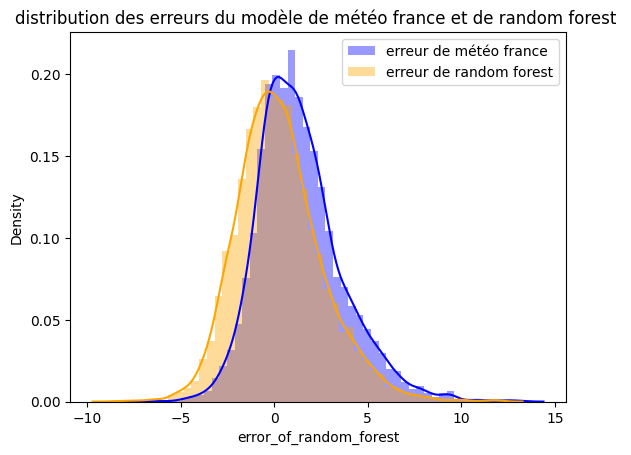

In [90]:
plt.figure()
sns.distplot(new_df['error_of meteo_france'],label='erreur de météo france', color='blue')
plt.title("distribution des erreurs du modèle de météo france et de random forest ")
sns.distplot(new_df['error_of_random_forest'],label='erreur de random forest', color='orange')
plt.legend()
plt.show()

Le modèle de random forest prédit donc des températures inférieures au températures réelles, tandis que le modèle de météo france prédit des températures plus élevées. Ainsi l'algorithme de random forest anticipe trop l'erreur de prévision de météo france et la corrige trop, ce qui le pousse à se tromper lui aussi

C:\Users\tsang\AppData\Local\Temp\ipykernel_11176\608874186.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(new_df['absolute_error of meteo  france'],label='erreur absolue de météo france', color='blue')
C:\Users\tsang\AppData\Local\Temp\ipykernel_11176\608874186.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750

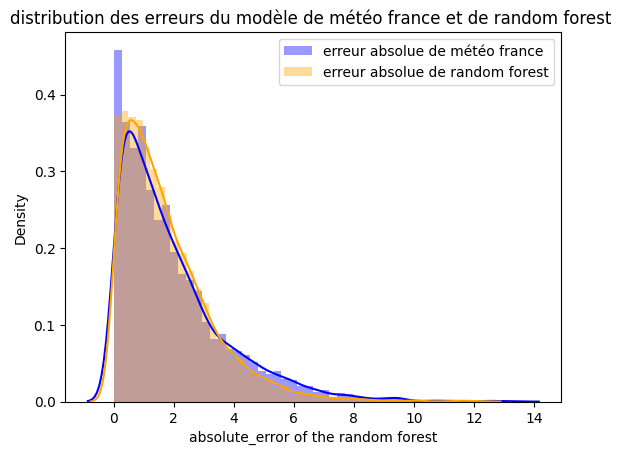

In [91]:
plt.figure()
sns.distplot(new_df['absolute_error of meteo  france'],label='erreur absolue de météo france', color='blue')
plt.title("distribution des erreurs du modèle de météo france et de random forest ")
sns.distplot(new_df['absolute_error of the random forest'],label='erreur absolue de random forest', color='orange')
plt.legend()
plt.show()

Lorsque l'on regarde la distribution des erreurs absolues, on voit bien que l'algorithme de random forest atténue foretment les grosses erreurs de prédiction,  ce qui lui permet de faire moins de grandes erreurs mais comme il corrige trop les petites erreurs aussi, cela le conduit à faire une erreur de signe opposé à celle de météo france. 

Le modèle de random forest a ainsi tendance à faire plus de petites erreurs de prédictions que le modèle de météo france, mais à faire mois d'erreurs dites inacceptables. 
Il est toutefois important de rappelé que l'algorithme de random forest utilise lui même les données de prédictions, ainsi il est très dépendant de la qualité même des prévisions initialement effectuées ! 



Pour conclure sur cette partie de prédiction : une meilleure compréhension des algorithme de prédiction et ici de l'algorithme de random forest premmettrait une meilleure comprhéensio des parmètres et donc dee réduire l'erreur effectuée par le modèle de random forest. 

# III. Une comparaison entre plusieurs pays

Après avoir étudié les données de façon ciblée, une approche plus macro peut être intéressante afin, d'une part, de déceler des différences entre les prévisions des différents modèles européens et, d'autre part, d'étudier de façon globale les disparités.

Une des difficultés que pose cette approche est la quantité de données à gérer. Elles sont considérables. Nous avons donc choisi, dans cette partie, de nous concentrer sur les données spatiales. C'est pourquoi nous ne conservons que les températures enregistrées le 2 décembre 2024 à midi, car c'est en journée que celles-ci sont les plus précises (cf. ci-dessus).


Dans cette partie, nous avons fait le choix d'étudier les Alpes pour pouvoir cibler quatre pays : la Suisse, la France, l'Italie et l'Autriche. Cependant, ce choix peut être discuté puisqu'il est apparu que les données étaient moins fiables en montagne. Nous allons d'une part chercher à vérifier cette affirmation et, d'autre part, à tenter de la quantifier. Le modèle de nos voisins helvétiques est-il plus fiable ?

Nous créons d'abord une fonction qui permet de générer des points aléatoires suivant une loi uniforme dans une zone géographique. Cette fonction est ensuite combinée avec l'API pour obtenir les données des températures. Nous utilisons une seed afin d'obtenir les mêmes points à chaque exécution du code, de sorte à avoir les mêmes points pour les températures enregistrées et l'historique des températures prédites.



In [92]:
def generate_random_points_alps(n_points=100, seed=42):

    random.seed(seed)

    # Définition des limites des Alpes
    alps_bounds = {
        'lat_min': 44.0,
        'lat_max': 48.0,
        'lon_min': 5.0,
        'lon_max': 16.0
    }
    
    points = []
    # Génération des coordonnées aléatoires
    for i in range (n_points):
        lats = np.random.uniform(alps_bounds['lat_min'], alps_bounds['lat_max'])
        lons = np.random.uniform(alps_bounds['lon_min'], alps_bounds['lon_max'])

        points.append((lats, lons))

    return points


def temperature_random_points_forecast(nb_points : int, seed: int = 42) -> pd.DataFrame  :

    # Liste des points aléatoires (exemple avec 2 points, étendre à 100 points)
    random_points = generate_random_points_alps(nb_points, seed)

    # Date unique pour la requête (remplacez par la date souhaitée)
    date = "2024-12-02"

    # Setup the Open-Meteo API client with cache and retry on error
    cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
    retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
    openmeteo = openmeteo_requests.Client(session=retry_session)

    # Créer un DataFrame consolidé pour stocker les résultats
    dataframes = []

    # Effectuer une requête pour chaque point
    for idx, (latitude, longitude) in enumerate(random_points, start=1):
        print(f"Traitement du point {idx}: Latitude = {latitude}, Longitude = {longitude}")

        # Paramètres de la requête pour chaque point
        params = {
            "latitude": latitude,
            "longitude": longitude,
            "hourly": "temperature_2m",
            "start_date": "2024-12-02",
	        "end_date": "2024-12-02",
        }

        try:
            # Effectuer la requête Open-Meteo
            responses = openmeteo.weather_api("https://historical-forecast-api.open-meteo.com/v1/forecast", params=params)
            response = responses[0]

            # Extraire les données horaires pour la température à 2m
            hourly = response.Hourly()
            hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()

            hourly_data = {
                "date": pd.date_range(
                    start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
                    end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
                    freq=pd.Timedelta(seconds=hourly.Interval()),
                    inclusive="left"
                ),
                "temperature_2m": hourly_temperature_2m
            }

            # Ajouter la latitude et la longitude aux données
            hourly_data["latitude"] = latitude
            hourly_data["longitude"] = longitude

            # Convertir en DataFrame et ajouter à la liste
            df = pd.DataFrame(data=hourly_data)
            dataframes.append(df)

        except Exception as e:
            print(f"Erreur lors du traitement du point {idx}: {e}")

    # Concaténation de  tous les DataFrames
    final_dataframe = pd.concat(dataframes, ignore_index=True)

    # Sauvegarder les résultats dans un fichier CSV
    final_dataframe.to_csv("weather_data.csv", index=False)

    result = final_dataframe.loc[final_dataframe["date"] == "2024-12-02 00:00:00+00:00"].rename(columns = {'temperature_2m' : 'temperature'})
    
    
    return result


def temperature_random_points_historical(nb_points : int, seed: int = 42) -> pd.DataFrame  :

    # Liste des points aléatoires (exemple avec 2 points, étendre à 100 points)
    random_points = generate_random_points_alps(nb_points, seed)

    # Date unique pour la requête (remplacez par la date souhaitée)
    date = "2024-12-02"

    # Setup the Open-Meteo API client with cache and retry on error
    cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
    retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
    openmeteo = openmeteo_requests.Client(session=retry_session)

    # Créer un DataFrame consolidé pour stocker les résultats
    dataframes = []

    # Effectuer une requête pour chaque point
    for idx, (latitude, longitude) in enumerate(random_points, start=1):
        print(f"Traitement du point {idx}: Latitude = {latitude}, Longitude = {longitude}")

        # Paramètres de la requête pour chaque point
        params = {
            "latitude": latitude,
            "longitude": longitude,
            "hourly": "temperature_2m",
            "start_date": date,
            "end_date": date,
            "models": "meteofrance_seamless"
        }

        try:
            # Effectuer la requête Open-Meteo
            responses = openmeteo.weather_api("https://archive-api.open-meteo.com/v1/archive", params=params)
            response = responses[0]

            # Extraire les données horaires pour la température à 2m
            hourly = response.Hourly()
            hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()

            hourly_data = {
                "date": pd.date_range(
                    start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
                    end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
                    freq=pd.Timedelta(seconds=hourly.Interval()),
                    inclusive="left"
                ),
                "temperature_2m": hourly_temperature_2m
            }

            # Ajouter la latitude et la longitude aux données
            hourly_data["latitude"] = latitude
            hourly_data["longitude"] = longitude

            # Convertir en DataFrame et ajouter à la liste
            df = pd.DataFrame(data=hourly_data)
            dataframes.append(df)

        except Exception as e:
            print(f"Erreur lors du traitement du point {idx}: {e}")

    # Concaténation de  tous les DataFrames
    final_dataframe = pd.concat(dataframes, ignore_index=True)

    # Sauvegarder les résultats dans un fichier CSV
    final_dataframe.to_csv("weather_data.csv", index=False)

    result = final_dataframe.loc[final_dataframe["date"] == "2024-12-02 00:00:00+00:00"].rename(columns = {'temperature_2m' : 'temperature'})
    
    
    return result
    # Création de la figure et de l'axe avec projection
    plt.figure(figsize=(15, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    # Définition des limites de la carte
    ax.set_extent([5, 16, 44, 48], crs=ccrs.PlateCarree())
    
    # Ajout des caractéristiques géographiques
    ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=0.5)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.RIVERS, alpha=0.5)
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    
    # Ajout du terrain
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    
    # Génération et ajout des points aléatoires
    lons, lats = generate_random_points_alps(n_points)
    plt.scatter(lons, lats, c='red', s=50, alpha=0.6, transform=ccrs.PlateCarree())
    
    # Ajout du quadrillage
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                     linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    
    # Titre
    plt.title('Points aléatoires dans les Alpes')
    
    return plt

In [93]:
result_historical_12_01 = temperature_random_points_historical(400, seed=123)
result_forecast_12_01 = temperature_random_points_forecast(400, seed=123)

Traitement du point 1: Latitude = 47.225189875995824, Longitude = 12.69422271854133
Traitement du point 2: Latitude = 44.25247928922667, Longitude = 7.415671428138086
Traitement du point 3: Latitude = 45.94500444672807, Longitude = 11.713279142539264
Traitement du point 4: Latitude = 44.56122510475039, Longitude = 9.038167939142689
Traitement du point 5: Latitude = 47.83812443106019, Longitude = 12.6837415124108
Traitement du point 6: Latitude = 44.94261335097424, Longitude = 9.15195063882775
Traitement du point 7: Latitude = 46.886524318046746, Longitude = 10.066383568166039
Traitement du point 8: Latitude = 46.67433156219889, Longitude = 14.533460162600022
Traitement du point 9: Latitude = 45.84465579910775, Longitude = 7.462208134148526
Traitement du point 10: Latitude = 45.57374217264119, Longitude = 13.19081644994977
Traitement du point 11: Latitude = 45.27380246104984, Longitude = 13.035374996769688
Traitement du point 12: Latitude = 46.81245291369089, Longitude = 7.3190156916980

In [94]:
historical = result_historical_12_01.reset_index()
forecast = result_forecast_12_01.reset_index()

result_diff_forecast_historical = historical.copy()
result_diff_forecast_historical['temperature'] = historical['temperature'] - forecast['temperature']

Après avoir généré 400 points nous contruisons le data frame des erreurs qui conciste à prendre les températures prédites et à soustraire leur prédiction. Un nombre positif dans la colonne de ce nouveau datframe signifiera donc que les températures ont été surestimées et un nombre négatif qu'elles ont été sous-estimées

Le code suivant est le coeur de cette partie, il définie l'interpolation, à partir de ces 400 points. Nous allons tenter d'établir une carte représentant les erreurs de prédiction. Ce code ressemble beaucoup à celui en introduction.

In [95]:
class TemperatureInterpolation:
    def __init__(self, dataframe):
        """
        Initialise l'interpolation avec un DataFrame pandas
        
        :param dataframe: DataFrame avec colonnes 'longitude', 'latitude', 'temperature'
        """
        self.points = dataframe[['longitude', 'latitude']].values
        self.temperatures = dataframe['temperature'].values
    
    def interpolate_idw(self, grid_shape=(500, 500), power=2):
        """
        Interpolation par Inverse Distance Weighting (IDW)
        
        :param grid_shape: Résolution de la grille de sortie
        :param power: Puissance pour le calcul des poids
        :return: Carte interpolée
        """
        x = np.linspace(5, 16, grid_shape[0])
        y = np.linspace(44, 48, grid_shape[1])
        grid_x, grid_y = np.meshgrid(x, y)
        
        interpolated = np.zeros_like(grid_x, dtype=float)
        for i in range(grid_x.shape[0]):
            for j in range(grid_x.shape[1]):
                point = np.array([grid_x[i,j], grid_y[i,j]])
                distances = np.linalg.norm(self.points - point, axis=1)
                distances = np.maximum(distances, 1e-10)
                weights = 1.0 / (distances ** power)
                weights /= np.sum(weights)
                interpolated[i,j] = np.sum(weights * self.temperatures)
        
        return interpolated, x, y
    
    def interpolate_triangulation(self, grid_shape=(500, 500)):
        """
        Interpolation par triangulation de Delaunay
        
        :param grid_shape: Résolution de la grille de sortie
        :return: Carte interpolée
        """
        x = np.linspace(5, 16, grid_shape[0])
        y = np.linspace(44, 48, grid_shape[1])
        grid_x, grid_y = np.meshgrid(x, y)
        
        interpolated = griddata(self.points, self.temperatures, 
                              (grid_x, grid_y), method='cubic')
        
        return interpolated, x, y
    
    def interpolate_rbf(self, grid_shape=(500, 500), function='thin_plate'):
        """
        Interpolation par Radial Basis Function (RBF)
        Particulièrement adaptée pour les données météorologiques
        
        :param grid_shape: Résolution de la grille de sortie
        :param function: Type de fonction RBF ('thin_plate', 'gaussian', 'multiquadric', 'inverse')
        :return: Carte interpolée
        """
        x = np.linspace(5, 16, grid_shape[0])
        y = np.linspace(44, 48, grid_shape[1])
        grid_x, grid_y = np.meshgrid(x, y)
        
        # Création de l'interpolateur RBF
        rbf = Rbf(self.points[:, 0], self.points[:, 1], self.temperatures,
                 function=function, smooth=0.3)
        
        # Application de l'interpolation
        interpolated = rbf(grid_x, grid_y)
        
        return interpolated, x, y
    
    def plot_interpolation(self, interpolated, x, y, title='Interpolation de Température'):
        """
        Visualiser l'interpolation avec la carte des Alpes
        
        :param interpolated: Grille interpolée
        :param x: Coordonnées x
        :param y: Coordonnées y
        :param title: Titre du graphique
        """
        plt.figure(figsize=(15, 10))
        ax = plt.axes(projection=ccrs.PlateCarree())
        
        # Définition des limites de la carte
        ax.set_extent([5, 16, 44, 48], crs=ccrs.PlateCarree())
        
        # Ajout des caractéristiques géographiques
        ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=0.5)
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.RIVERS, alpha=0.5)
        ax.add_feature(cfeature.LAKES, alpha=0.5)
        ax.add_feature(cfeature.LAND, alpha=0.3)
        
        # Affichage de l'interpolation
        im = ax.imshow(interpolated, 
                      extent=[x.min(), x.max(), y.min(), y.max()],
                      origin='lower',
                      cmap='RdBu_r',  # Colormap adapté pour la température
                      alpha=0.7,
                      transform=ccrs.PlateCarree())
        
        # Ajout du quadrillage
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                         linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        
        # Barre de couleur
        plt.colorbar(im, label='Température (°C)')
        
        plt.title(title)
        plt.tight_layout()
        plt.show()
    
    def interpolate_and_plot(self, method='idw', **kwargs):
        """
        Interpoler et tracer la carte
        
        :param method: Méthode d'interpolation ('idw', 'triangulation', ou 'rbf')
        :param kwargs: Paramètres supplémentaires pour la méthode
        """
        if method.lower() == 'idw':
            interpolated, x, y = self.interpolate_idw(**kwargs)
        elif method.lower() == 'triangulation':
            interpolated, x, y = self.interpolate_triangulation(**kwargs)
        elif method.lower() == 'rbf':
            interpolated, x, y = self.interpolate_rbf(**kwargs)
        else:
            raise ValueError("Méthode non reconnue. Choisissez 'idw', 'triangulation' ou 'rbf'.")
        
        self.plot_interpolation(interpolated, x, y, 
                              title=f'Interpolation de Température - Méthode {method}')

def interpoler_carte(resultat, methode='idw'):
    """
    Fonction principale pour interpoler et tracer la carte
    
    :param resultat: DataFrame pandas avec colonnes 'temperature', 'longitude', 'latitude'
    :param methode: Méthode d'interpolation à utiliser
    """
    interpolator = TemperatureInterpolation(resultat)
    interpolator.interpolate_and_plot(method=methode)

Avant d'afficher la carte l'utilisation de la méthode .describe() permet d'évaluer rapidement les résultats du modèle. Il appraît que grossièrement le modèle à tendance à légèrement sous estimer la température. cependant malgrès quelques point aberrant avec des écarts de plus de 20 degré.

In [96]:
result_diff_forecast_historical.describe()

index  temperature    latitude   longitude
count   400.000000   400.000000  400.000000  400.000000
mean   4788.000000    -1.302601   46.018637   10.848606
std    2774.743231     6.913765    1.118166    3.227246
min       0.000000   -28.232500   44.006231    5.015787
25%    2394.000000    -5.790750   45.063373    8.003240
50%    4788.000000    -1.001750   45.966026   10.734588
75%    7182.000000     2.738000   46.971157   13.864024
max    9576.000000    25.214001   47.996005   15.996196

En poussant la recherche un peu plus loins, on constate que 80% des données possèdent un écart de moins de 10°C avec les températures enregistrées. Le modèle semble donc peu fiable dans les Alpes en hiver

In [97]:
lower_bound = result_diff_forecast_historical['temperature'].quantile(0.10)
upper_bound = result_diff_forecast_historical['temperature'].quantile(0.90)

print(f"L'intervalle contenant 80% des données est : [{lower_bound}, {upper_bound}]")

L'intervalle contenant 80% des données est : [-9.841250133514404, 6.917799806594853]


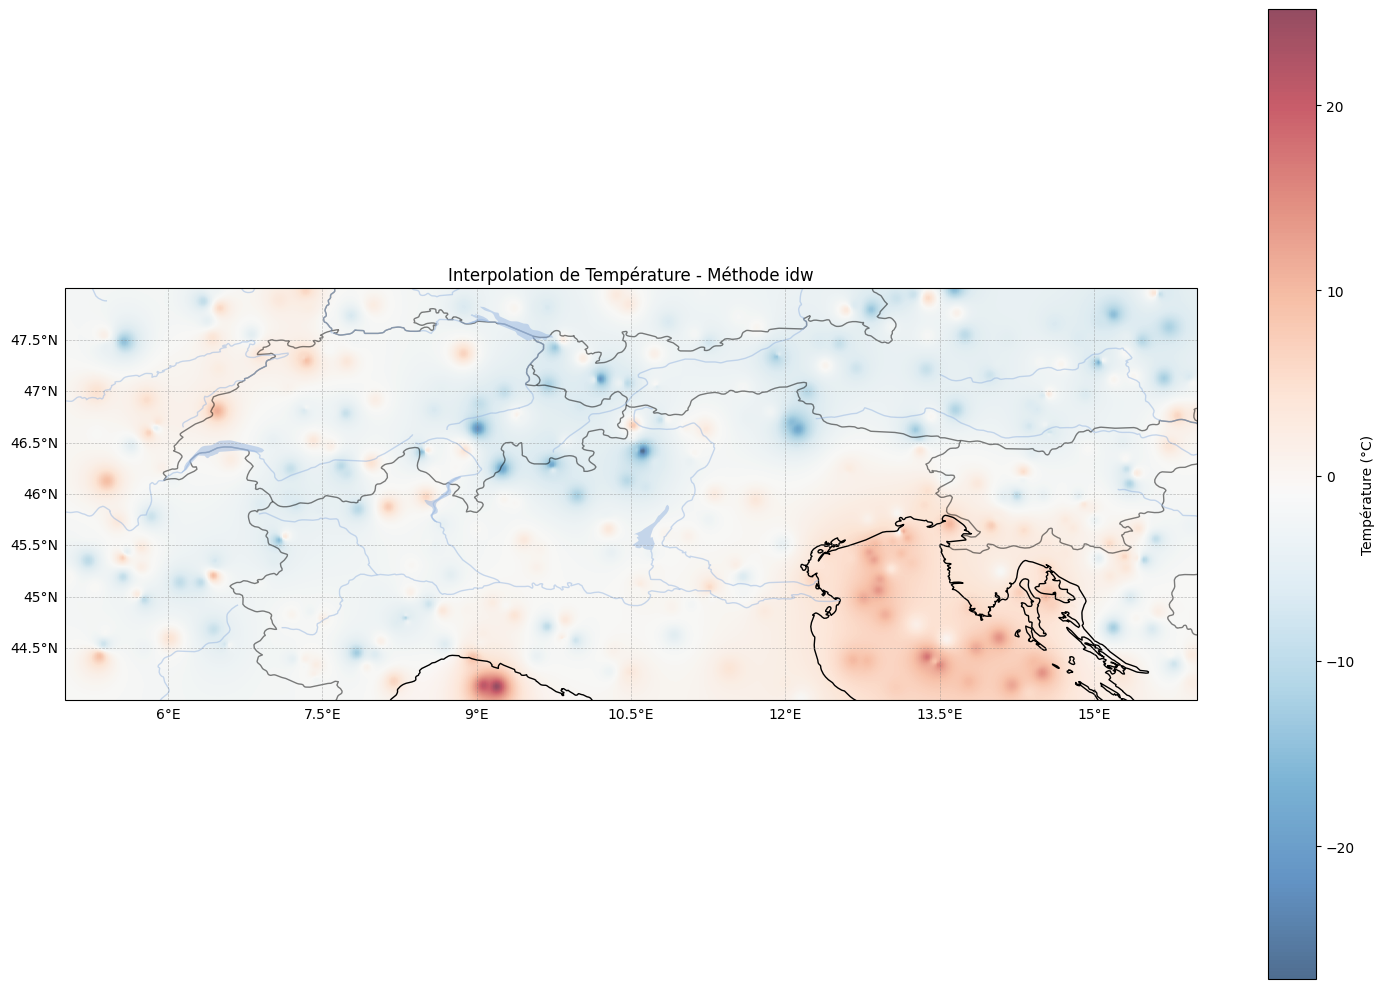

In [98]:
interpoler_carte(result_diff_forecast_historical, methode='idw')

On constate que le modèle de meteo France à tendance à surestimer les tempérture là ou le modèle Autrichien aurait tendance à le sous estimer
On peut aussi constater que le modèle est globalement moins précis en montagne et en mer due, aux changement plus rapide de température

On peut finir par une comparaison des méthodes d'interpolation

In [99]:
def compare_interpolation_methods(dataframe, show_points=True, point_size=50):
    """
    Affiche les trois méthodes d'interpolation côte à côte
    
    :param dataframe: DataFrame avec colonnes 'longitude', 'latitude', 'temperature'
    :param show_points: Boolean pour afficher ou non les points de données
    :param point_size: Taille des points (si affichés)
    """
    # Création de l'interpolateur
    interpolator = TemperatureInterpolation(dataframe)
    
    # Configuration de la figure
    fig = plt.figure(figsize=(20, 8))
    
    # Liste des méthodes à comparer
    methods = ['idw', 'triangulation', 'rbf']
    titles = ['IDW', 'Triangulation de Delaunay', 'RBF (Radial Basis Function)']
    
    # Calcul des bornes globales pour l'échelle de couleur
    min_temp = dataframe['temperature'].min()
    max_temp = dataframe['temperature'].max()
    temp_range = max_temp - min_temp
    vmin, vmax = min_temp - 0.1*temp_range, max_temp + 0.1*temp_range
    
    # Création des subplots
    for idx, (method, title) in enumerate(zip(methods, titles), 1):
        # Création de l'axe avec projection
        ax = fig.add_subplot(1, 3, idx, projection=ccrs.PlateCarree())
        
        # Obtention des données interpolées
        if method == 'idw':
            interpolated, x, y = interpolator.interpolate_idw(grid_shape=(200, 200))
        elif method == 'triangulation':
            interpolated, x, y = interpolator.interpolate_triangulation(grid_shape=(200, 200))
        else:  # rbf
            interpolated, x, y = interpolator.interpolate_rbf(grid_shape=(200, 200))
        
        # Clipper les valeurs aux bornes
        interpolated = np.clip(interpolated, vmin, vmax)
        
        # Définition des limites de la carte
        ax.set_extent([5, 16, 44, 48], crs=ccrs.PlateCarree())
        
        # Ajout des caractéristiques géographiques
        ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=0.5)
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.RIVERS, alpha=0.5)
        ax.add_feature(cfeature.LAKES, alpha=0.5)
        ax.add_feature(cfeature.LAND, alpha=0.3)
        
        # Affichage de l'interpolation
        im = ax.imshow(interpolated,
                      extent=[x.min(), x.max(), y.min(), y.max()],
                      origin='lower',
                      cmap='RdBu_r',
                      alpha=0.7,
                      vmin=vmin,
                      vmax=vmax,
                      transform=ccrs.PlateCarree())
        
        # Ajout des points si demandé
        if show_points:
            scatter = ax.scatter(interpolator.points[:,0], 
                               interpolator.points[:,1],
                               c=interpolator.temperatures,
                               cmap='RdBu_r',
                               edgecolor='black',
                               s=point_size,
                               vmin=vmin,
                               vmax=vmax,
                               transform=ccrs.PlateCarree())
        
        # Ajout du quadrillage
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                         linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        
        # Titre de chaque carte
        ax.set_title(title)
        
        # Ajout de la barre de couleur
        plt.colorbar(im, ax=ax, label='Température (°C)', shrink=0.8)
    
    # Titre général
    plt.suptitle('Comparaison des méthodes d\'interpolation de température', y=1.05, fontsize=16)
    
    # Ajustement de la mise en page
    plt.tight_layout()
    
    # Affichage
    plt.show()

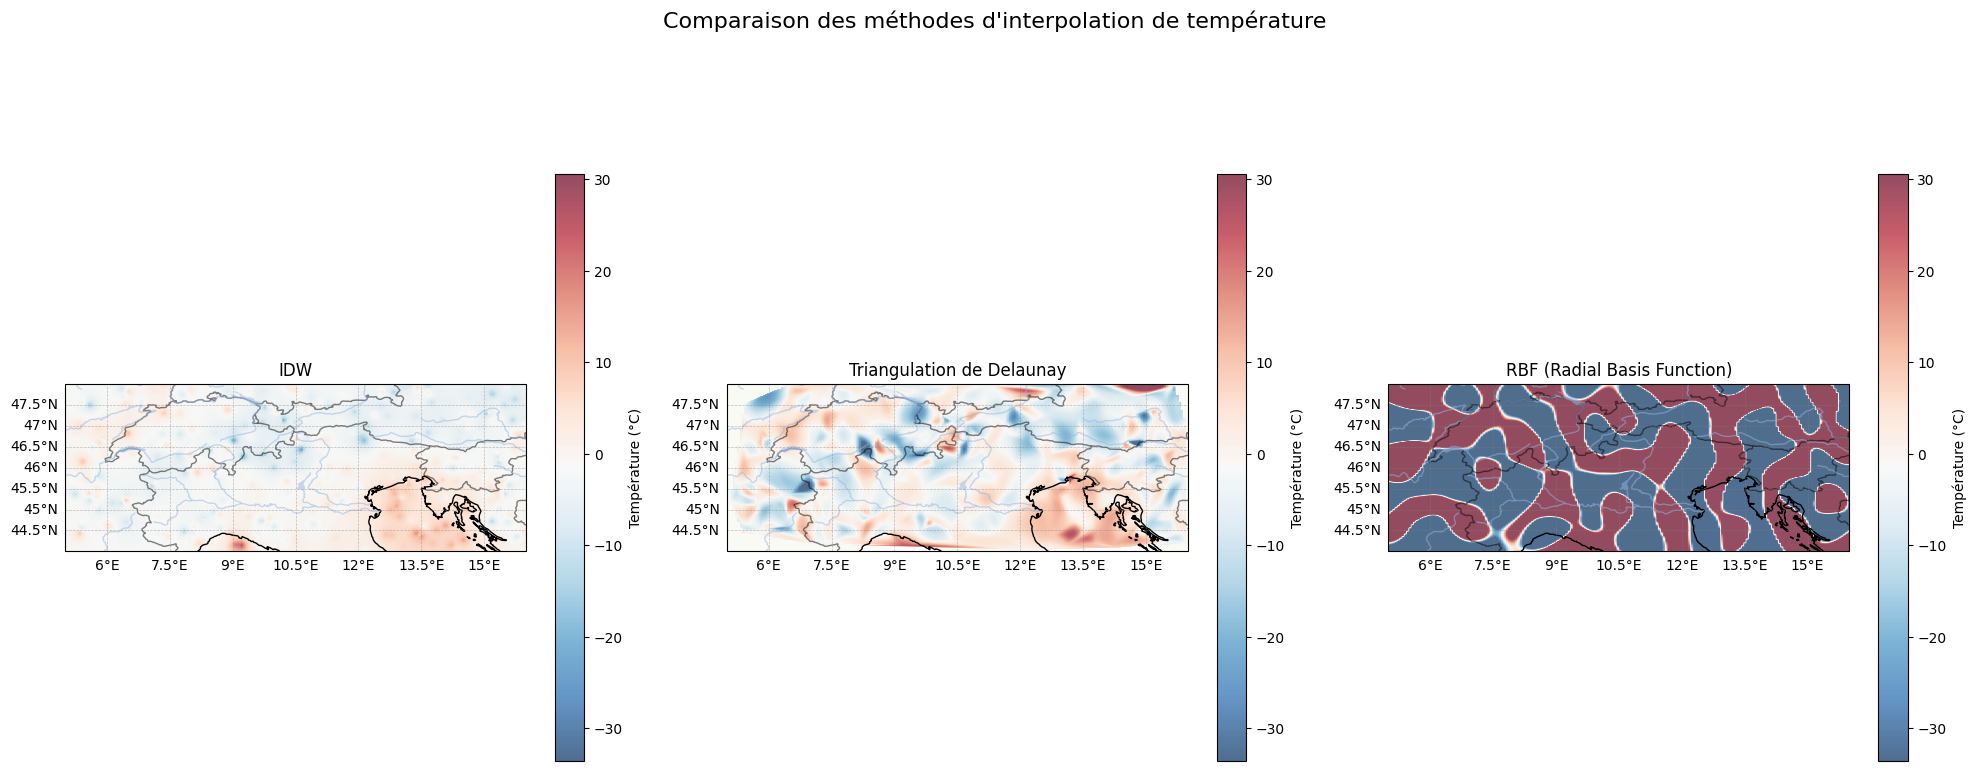

In [100]:
compare_interpolation_methods(result_diff_forecast_historical, show_points=False)

L'interpolation triangulaire de Delaunay accentue d'autant plus les différences mais du à sa méthode de calcule, les frontières des triangles peuvent appraître comme artificiel. En effet  c'est une méthode linéaire qui ne tient compte que des voisins directs. Elle peut produire des discontinuités ou des artefacts dans les zones où les gradients de température sont élevés ou où les données sont irrégulièrement espacées. A l'inverse l’IDW (Inverse Distance Weighting) est une méthode d’interpolation basée sur la distance pondérée entre les points de données connus et le point cible x. Enfin la méthode rbf peut donner de bon résultat mais dépend essentiellment du bon choix des paramètres et peut être difficile à qualibrer. Les résultat obtenue ici ne nous on pas parut satisfaisant.

Une approxiamtion grossière des frontières de la France et de l'Autriche confirme nos premières analyses, le modèle français semble plus fiable que le modèle Autrichien où les températures sont très majoritairement sous estimées

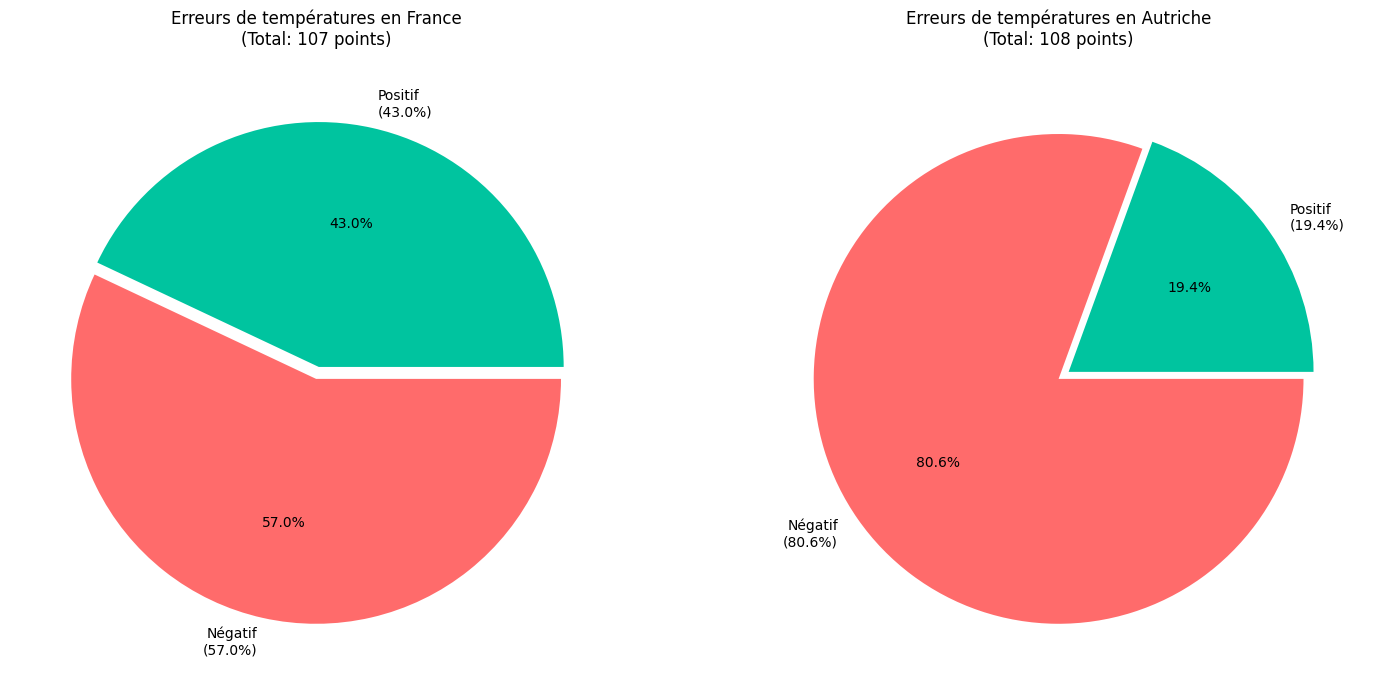


Statistiques détaillées:
France:
- Nombre total de points: 107
- Points positifs: 43.0%
- Erreur moyenne: -1.51°C

Autriche:
- Nombre total de points: 108
- Points positifs: 19.4%
- Erreur moyenne: -5.03°C


In [101]:
def is_in_france(lat, lon):
    """Vérifie si un point est en France métropolitaine (approximation par bounding box)"""
    return (42.33 <= lat <= 51.12) and (-4.79 <= lon <= 8.23)

def is_in_austria(lat, lon):
    """Vérifie si un point est en Autriche (approximation par bounding box)"""
    return (46.37 <= lat <= 49.02) and (9.53 <= lon <= 17.17)


def analyze_temperatures_by_country(df):
    """Analyse les températures par pays et crée un graphique camembert"""
    
    # Identification des points dans chaque pays
    df['in_france'] = df.apply(lambda row: is_in_france(row['latitude'], row['longitude']), axis=1)
    df['in_austria'] = df.apply(lambda row: is_in_austria(row['latitude'], row['longitude']), axis=1)
    
    # Calcul des proportions
    france_data = df[df['in_france']]
    austria_data = df[df['in_austria']]
    
    france_positive = (france_data['temperature'] > 0).mean() * 100
    austria_positive = (austria_data['temperature'] > 0).mean() * 100
    
    # Création des graphiques
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
    
    # Graphique France
    france_values = [france_positive, 100 - france_positive]
    ax1.pie(france_values, 
            labels=[f'Positif\n({france_positive:.1f}%)', f'Négatif\n({100-france_positive:.1f}%)'], 
            colors=['#00C49F', '#ff6b6b'],
            autopct='%1.1f%%',
            explode=(0.05, 0))
    ax1.set_title('Erreurs de températures en France\n' + f'(Total: {len(france_data)} points)', pad=20)
    
    # Graphique Autriche
    austria_values = [austria_positive, 100 - austria_positive]
    ax2.pie(austria_values, 
            labels=[f'Positif\n({austria_positive:.1f}%)', f'Négatif\n({100-austria_positive:.1f}%)'],
            colors=['#00C49F', '#ff6b6b'],
            autopct='%1.1f%%',
            explode=(0.05, 0))
    ax2.set_title('Erreurs de températures en Autriche\n' + f'(Total: {len(austria_data)} points)', pad=20)
    
    plt.tight_layout()
    plt.show()
    
    # Afficher les statistiques détaillées
    print("\nStatistiques détaillées:")
    print(f"France:")
    print(f"- Nombre total de points: {len(france_data)}")
    print(f"- Points positifs: {france_positive:.1f}%")
    if len(france_data) > 0:
        print(f"- Erreur moyenne: {france_data['temperature'].mean():.2f}°C")
    
    print(f"\nAutriche:")
    print(f"- Nombre total de points: {len(austria_data)}")
    print(f"- Points positifs: {austria_positive:.1f}%")
    if len(austria_data) > 0:
        print(f"- Erreur moyenne: {austria_data['temperature'].mean():.2f}°C")
    
    return {
        'france_stats': {
            'positive_percentage': france_positive,
            'total_points': len(france_data),
            'mean_temp': france_data['temperature'].mean() if len(france_data) > 0 else None
        },
        'austria_stats': {
            'positive_percentage': austria_positive,
            'total_points': len(austria_data),
            'mean_temp': austria_data['temperature'].mean() if len(austria_data) > 0 else None
        }
    }

# Utilisation
stats = analyze_temperatures_by_country(result_diff_forecast_historical)

# Conclusion

Finalement, les prévisions météorologiques sont très difficiles à faire précisément, ce qui entraîne de grandes variations entre les prédictions et la réalité. Comme nous l'avons vu, la qualité des prédictions dépend grandement de la localisation étudiée, du mois pour lequel la prédiction est faite et de l'heure également. C'est donc un sujet complexe mais qui passionne autant les secteurs public (tel que Météo France) que privé (Google ayant annoncé la sortie prochaine d'une intelligence artificielle capable de mieux prédire la météo sur 15 jours !). Ainsi, nous pouvons nous fier à Météo France, dans la mesure où ses erreurs sont souvent acceptables, et en attendant d'avoir de meilleurs modèles, nous n'avons de toute façon pas mieux !